# Nuclear chromatin phenotypes of PBMCs reflects the treatment effect of proton therapy (Glioma)

---
This notebook summarizes the analysis corresponding to the results presented in figure 4 of the paper for Glioma patients. It can be used to rerun the analysis and regenerate the corresponding panels.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300

import sys

sys.path.append("../..")
from src.utils.notebooks.eda import *
from src.utils.notebooks.figure3 import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, StratifiedGroupKFold

seed = 1234
random.seed(1234)
np.random.seed(1234)

%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
nuc_feature_desc = pd.read_csv(
    "../../data/chrometric_feature_description.csv", index_col=0
)
feature_name_dict = dict(
    zip(
        list(nuc_feature_desc.loc[:, "feature"]),
        list(nuc_feature_desc.loc[:, "long_name"]),
    )
)
feature_color_dict = {
    "morphology": "b",
    "intensity": "g",
    "boundary": "r",
    "texture": "c",
    "chromatin condensation": "m",
    "moments": "y",
    np.nan: "k",
}
feature_color_dict = {
    feature: feature_color_dict[category]
    for (feature, category) in zip(
        list(nuc_feature_desc.loc[:, "long_name"]),
        list(nuc_feature_desc.loc[:, "category"]),
    )
}

<IPython.core.display.Javascript object>

In [3]:
color_palette = {
    "prior": "orange",
    "during": "gold",
    "end": "saddlebrown",
}

<IPython.core.display.Javascript object>

---

## 1. Read in data

In this notebook we assess the differences of the cell states of PBMCs at three different time points of the proton therapy treatment: before, during (~3 weeks in) and at the end of the treatment (final week of treatment). To this end, we obtained PBMCs of 8 Glioma patients stained them for DNA, gH2AX and Lamin A/C and obtained fluorescent images.

First, we read in the required data set that describe each PBMCs by a number of hand-crafted features extracted from the fluorescent images of the cells.

In [4]:
tp1_root_data_dir = "../../data/glioma/proteins/timepoint_1"
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"
gh2ax_foci_result_file_path = "/preprocessed/full_pipeline/gh2ax_foci_feats.csv"

<IPython.core.display.Javascript object>

In [5]:
tp1_data = read_in_protein_dataset(
    data_dir=tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    gh2ax_foci_result_file_path=gh2ax_foci_result_file_path,
)
tp1_data["id"] = tp1_data["sample"] + tp1_data["timepoint"]
tp1_data["timepoint"] = "prior"
tp1_data["file_name"] = np.array(list(tp1_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 26.05it/s]


<IPython.core.display.Javascript object>

In [6]:
tp2_root_data_dir = "../../data/glioma/proteins/timepoint_2"

tp2_data = read_in_protein_dataset(
    data_dir=tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    gh2ax_foci_result_file_path=gh2ax_foci_result_file_path,
)
tp2_data["id"] = tp2_data["sample"] + tp2_data["timepoint"]
tp2_data["timepoint"] = "during"
tp2_data["file_name"] = np.array(list(tp2_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 22.02it/s]


<IPython.core.display.Javascript object>

In [7]:
tp3_root_data_dir = "../../data/glioma/proteins/timepoint_3"

tp3_data = read_in_protein_dataset(
    data_dir=tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    gh2ax_foci_result_file_path=gh2ax_foci_result_file_path,
)
tp3_data["id"] = tp3_data["sample"] + tp3_data["timepoint"]
tp3_data["timepoint"] = "end"
tp3_data["file_name"] = np.array(list(tp3_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 19.36it/s]


<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Before we analyze the data, we will first preprocess it.

To this end, we first remove features with missing values and samples with missing features.

In [8]:
tp1_data = preprocess_data(tp1_data, remove_constant_features=False)
tp2_data = preprocess_data(tp2_data, remove_constant_features=False)
tp3_data = preprocess_data(tp3_data, remove_constant_features=False)

all_data = tp1_data.append(tp2_data).append(tp3_data)
all_data.index = all_data["id"] + "_" + all_data.index

Nuclei that did not pass the quality check: 132/4016. Remaining: 3884.
Removed 12 constant or features with missing values. Remaining: 292.
Removed additional 6 features. Remaining: 286.
Nuclei that did not pass the quality check: 374/5465. Remaining: 5091.
Removed 9 constant or features with missing values. Remaining: 295.
Removed additional 6 features. Remaining: 289.
Nuclei that did not pass the quality check: 437/5059. Remaining: 4622.
Removed 12 constant or features with missing values. Remaining: 292.
Removed additional 6 features. Remaining: 286.


<IPython.core.display.Javascript object>

In [9]:
all_data = all_data.rename(columns=feature_name_dict)

<IPython.core.display.Javascript object>

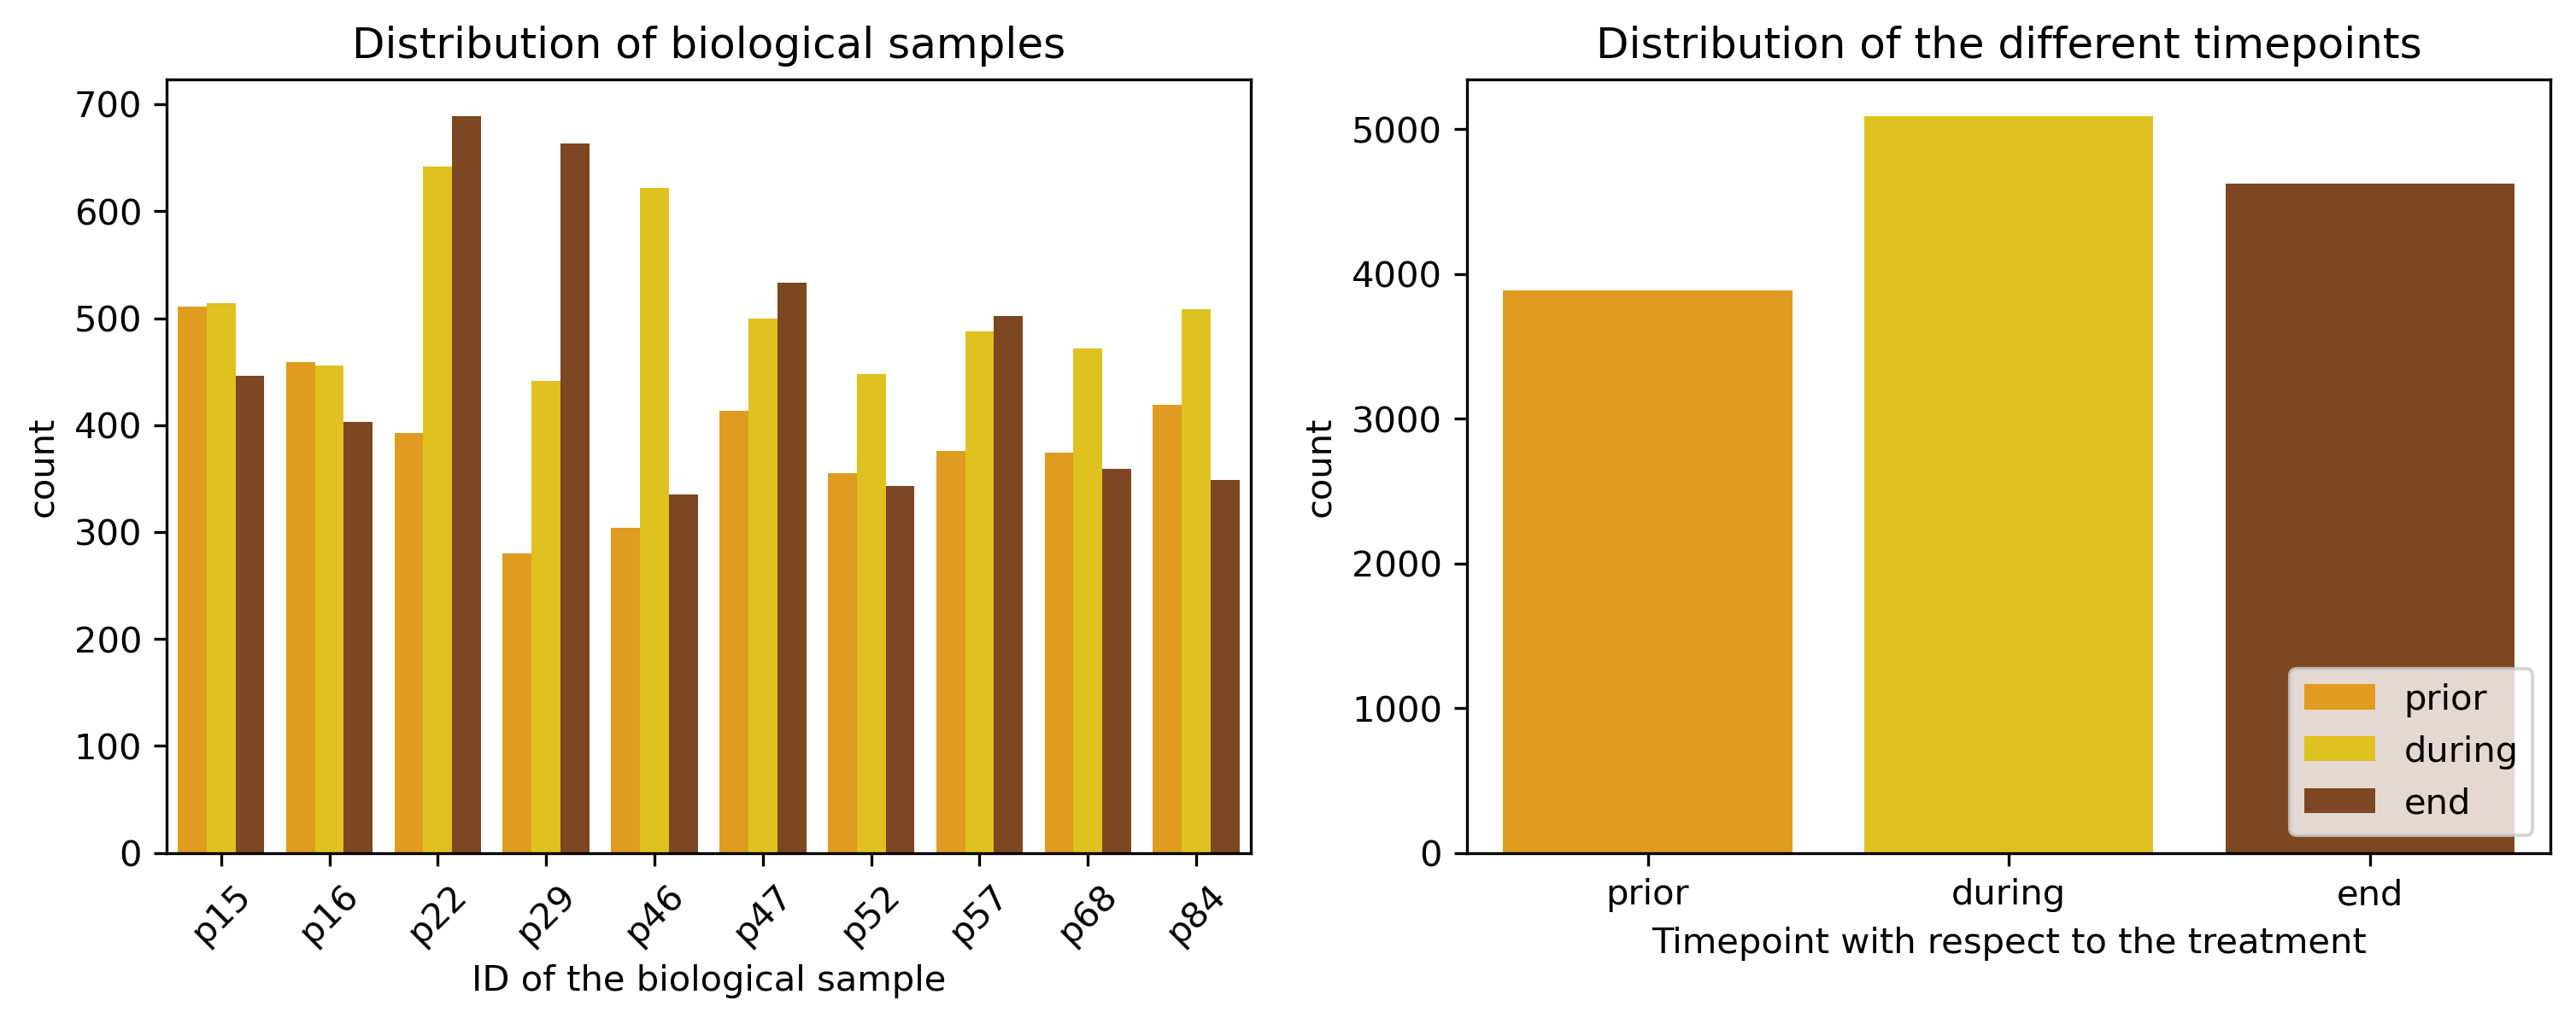

<IPython.core.display.Javascript object>

In [10]:
fig, ax = plt.subplots(figsize=[12, 4], ncols=2)
tp_order = ["prior", "during", "end"]
sample_order = np.unique(all_data.loc[:, "sample"])
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=all_data,
    ax=ax[0],
    order=sample_order,
    hue_order=tp_order,
    hue="timepoint",
    palette=color_palette,
)
ax[0].legend([], [], frameon=False)
ax[0].set_xlabel("ID of the biological sample")
ax[0].set_title("Distribution of biological samples")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1] = sns.countplot(
    x="timepoint",
    hue="timepoint",
    data=all_data,
    ax=ax[1],
    order=tp_order,
    dodge=False,
    palette=color_palette,
)
ax[1].set_xlabel("Timepoint with respect to the treatment")
ax[1].set_title("Distribution of the different timepoints")
ax[1].legend(loc="lower right")

plt.show()
plt.close()

___

#### Subsampling

We next subsample the data set such that for each timepoint we have the same number of nuclei in the data set. Additionally, we ensure that the individual timepoint population are approximately uniformly represented by the different biological (patient) samples.

In [11]:
sampled_data = get_stratified_data(
    all_data, id_column="id", cond_column="timepoint", seed=1234
)

<IPython.core.display.Javascript object>

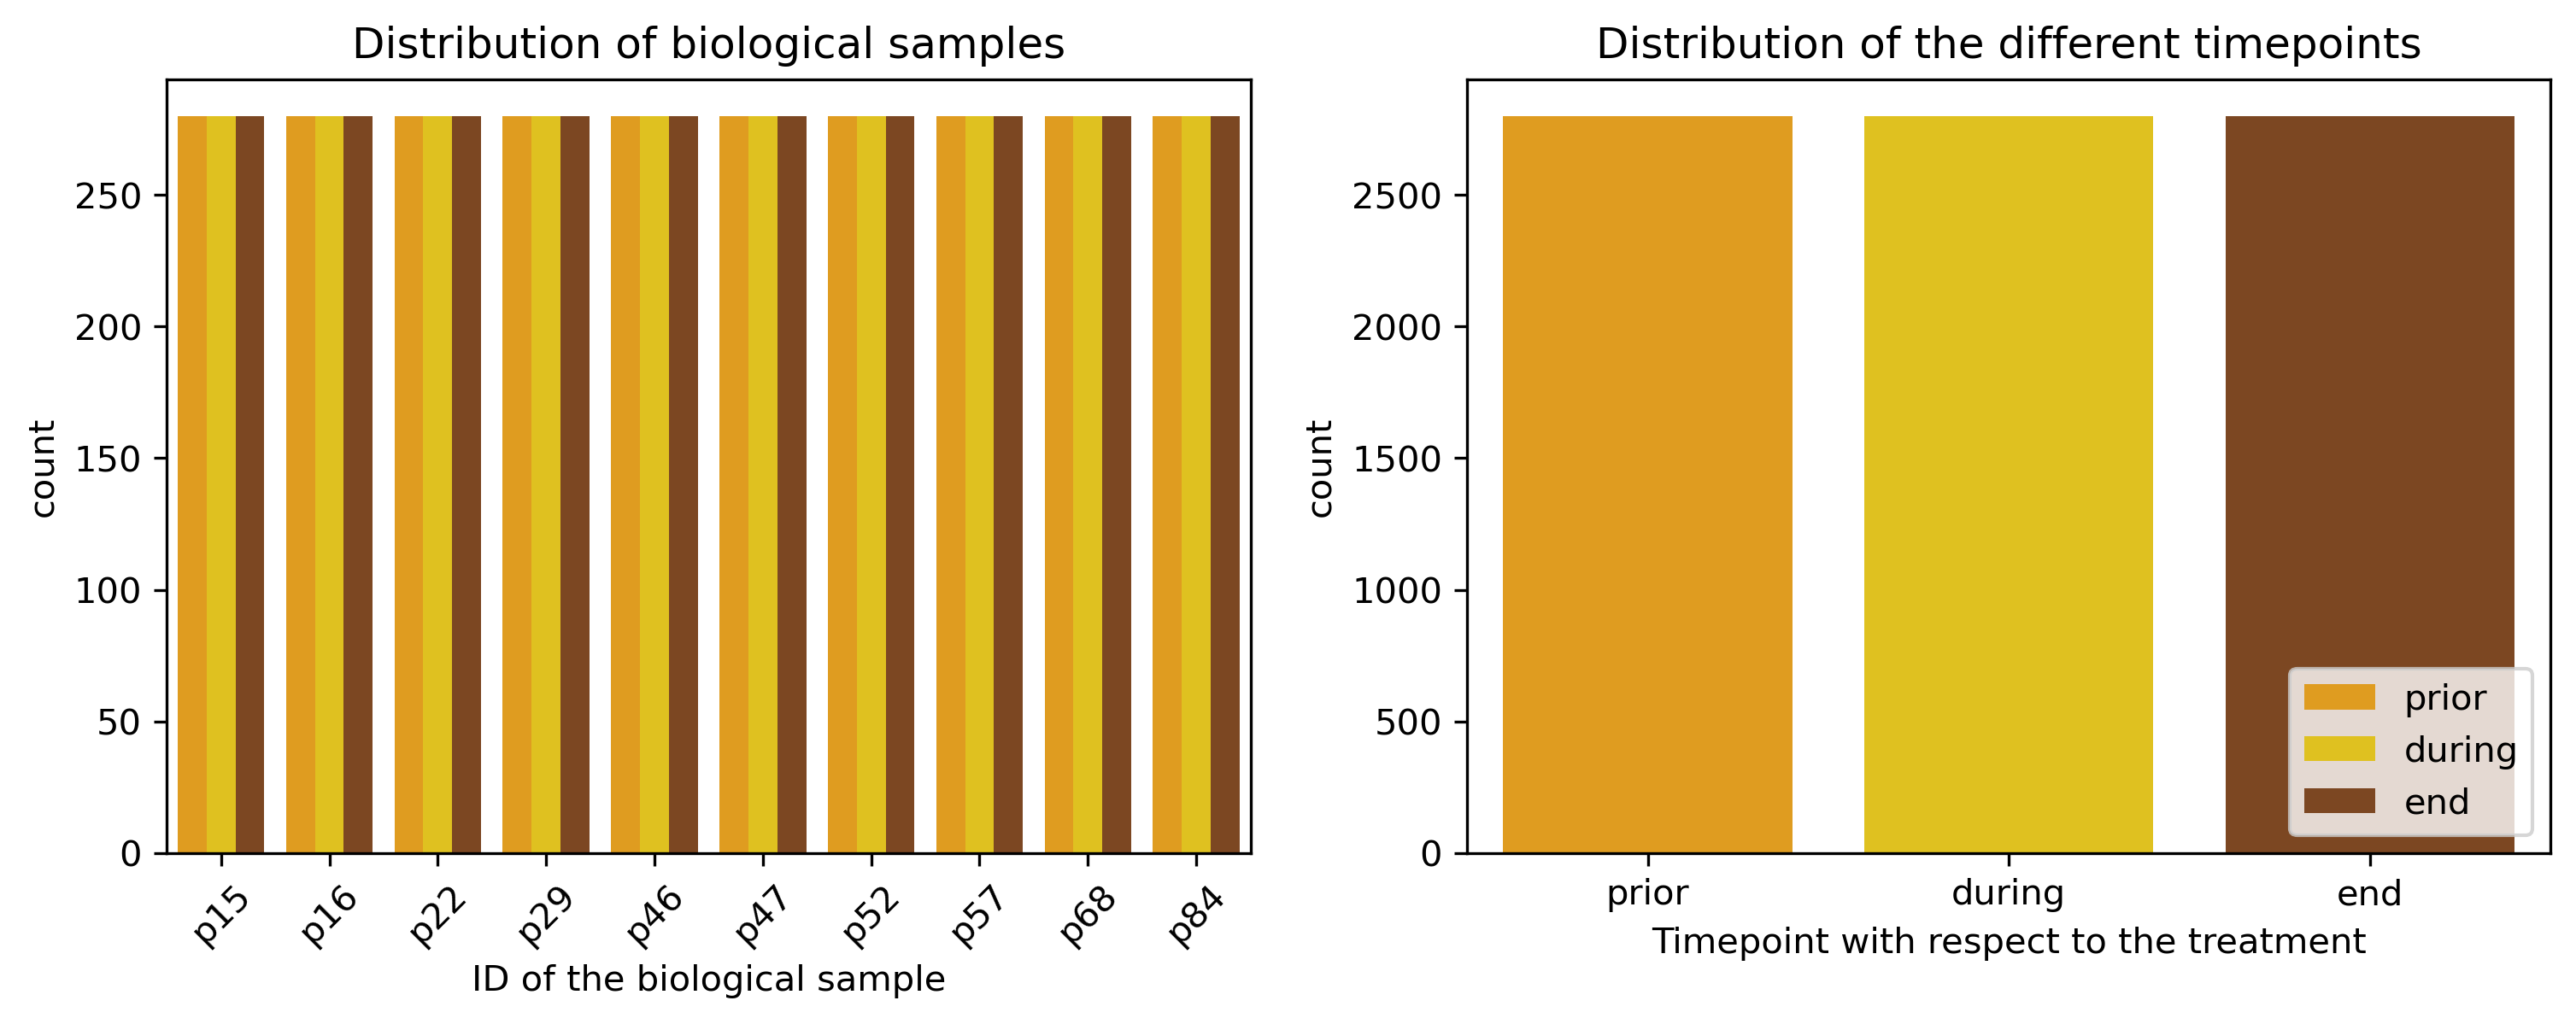

<IPython.core.display.Javascript object>

In [12]:
fig, ax = plt.subplots(figsize=[12, 4], ncols=2)
tp_order = ["prior", "during", "end"]
sample_order = np.unique(all_data.loc[:, "sample"])
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=sampled_data,
    ax=ax[0],
    order=sample_order,
    hue_order=tp_order,
    hue="timepoint",
    palette=color_palette,
)
ax[0].legend([], [], frameon=False)
ax[0].set_xlabel("ID of the biological sample")
ax[0].set_title("Distribution of biological samples")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1] = sns.countplot(
    x="timepoint",
    hue="timepoint",
    data=sampled_data,
    ax=ax[1],
    order=tp_order,
    hue_order=tp_order,
    dodge=False,
    palette=color_palette,
)
ax[1].set_xlabel("Timepoint with respect to the treatment")
ax[1].set_title("Distribution of the different timepoints")
ax[1].legend(loc="lower right")

plt.show()
plt.close()

----

#### Sample and feature selection

We now filter out constant features and nuclei with missing features.

In [13]:
data = preprocess_data(sampled_data, remove_constant_features=True)

Nuclei that did not pass the quality check: 0/8400. Remaining: 8400.
Removed 8 constant or features with missing values. Remaining: 281.
Removed additional 0 features. Remaining: 281.


<IPython.core.display.Javascript object>

---

#### Data preparation

After sampling the data, we will now prepare the data for the consecutive analysis, i.e. extracting only chrometric features and corresponding metadata information.

In [14]:
all_chrometric_data = get_chrometric_data(
    data,
    proteins=["gh2ax", "lamin", "cd3"],
    exclude_dna_int=True,
)

sample_labels = data.loc[:, "sample"]
tp_labels = data.loc[:, "timepoint"]

<IPython.core.display.Javascript object>

Finally, we remove highly correlated features (Pearson $\rho > 0.8$) from the chrometric features.

In [15]:
chrometric_data = remove_correlated_features(all_chrometric_data, threshold=0.8)

Removed 133/192 features with a Pearson correlation above 0.8. Remaining: 59


<IPython.core.display.Javascript object>

---

## 3. Panels

Now we generate the individual panels for figure 3 of the paper.


### 3a. Visualization of changes of nuclear phenotypes in different cancer types

First, we provide a visual representation of the different nuclear phenotypes in health and cancer. To this end, we will randomly sample 36 nuclei from each of the three cancer types and plot a corresponding montage of the max-z projected DNA images. To visualize size differences each nuclei is padded to a size of 150x150 pixels. Note that the nuclei images were obtained from range-normalized DAPI images. The range normalization was used to mitigate batch effects.

In [16]:
image_file_path = "preprocessed/full_pipeline/segmentation/nuclei_images"
sampled_tp1_images = get_random_images(
    data.loc[data.timepoint == "prior"],
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
    file_name_col="file_name",
)

sampled_tp2_images = get_random_images(
    data.loc[data.timepoint == "during"],
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
    file_name_col="file_name",
)

sampled_tp3_images = get_random_images(
    data.loc[data.timepoint == "end"],
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
    file_name_col="file_name",
)

<IPython.core.display.Javascript object>

#### Prior treatment population

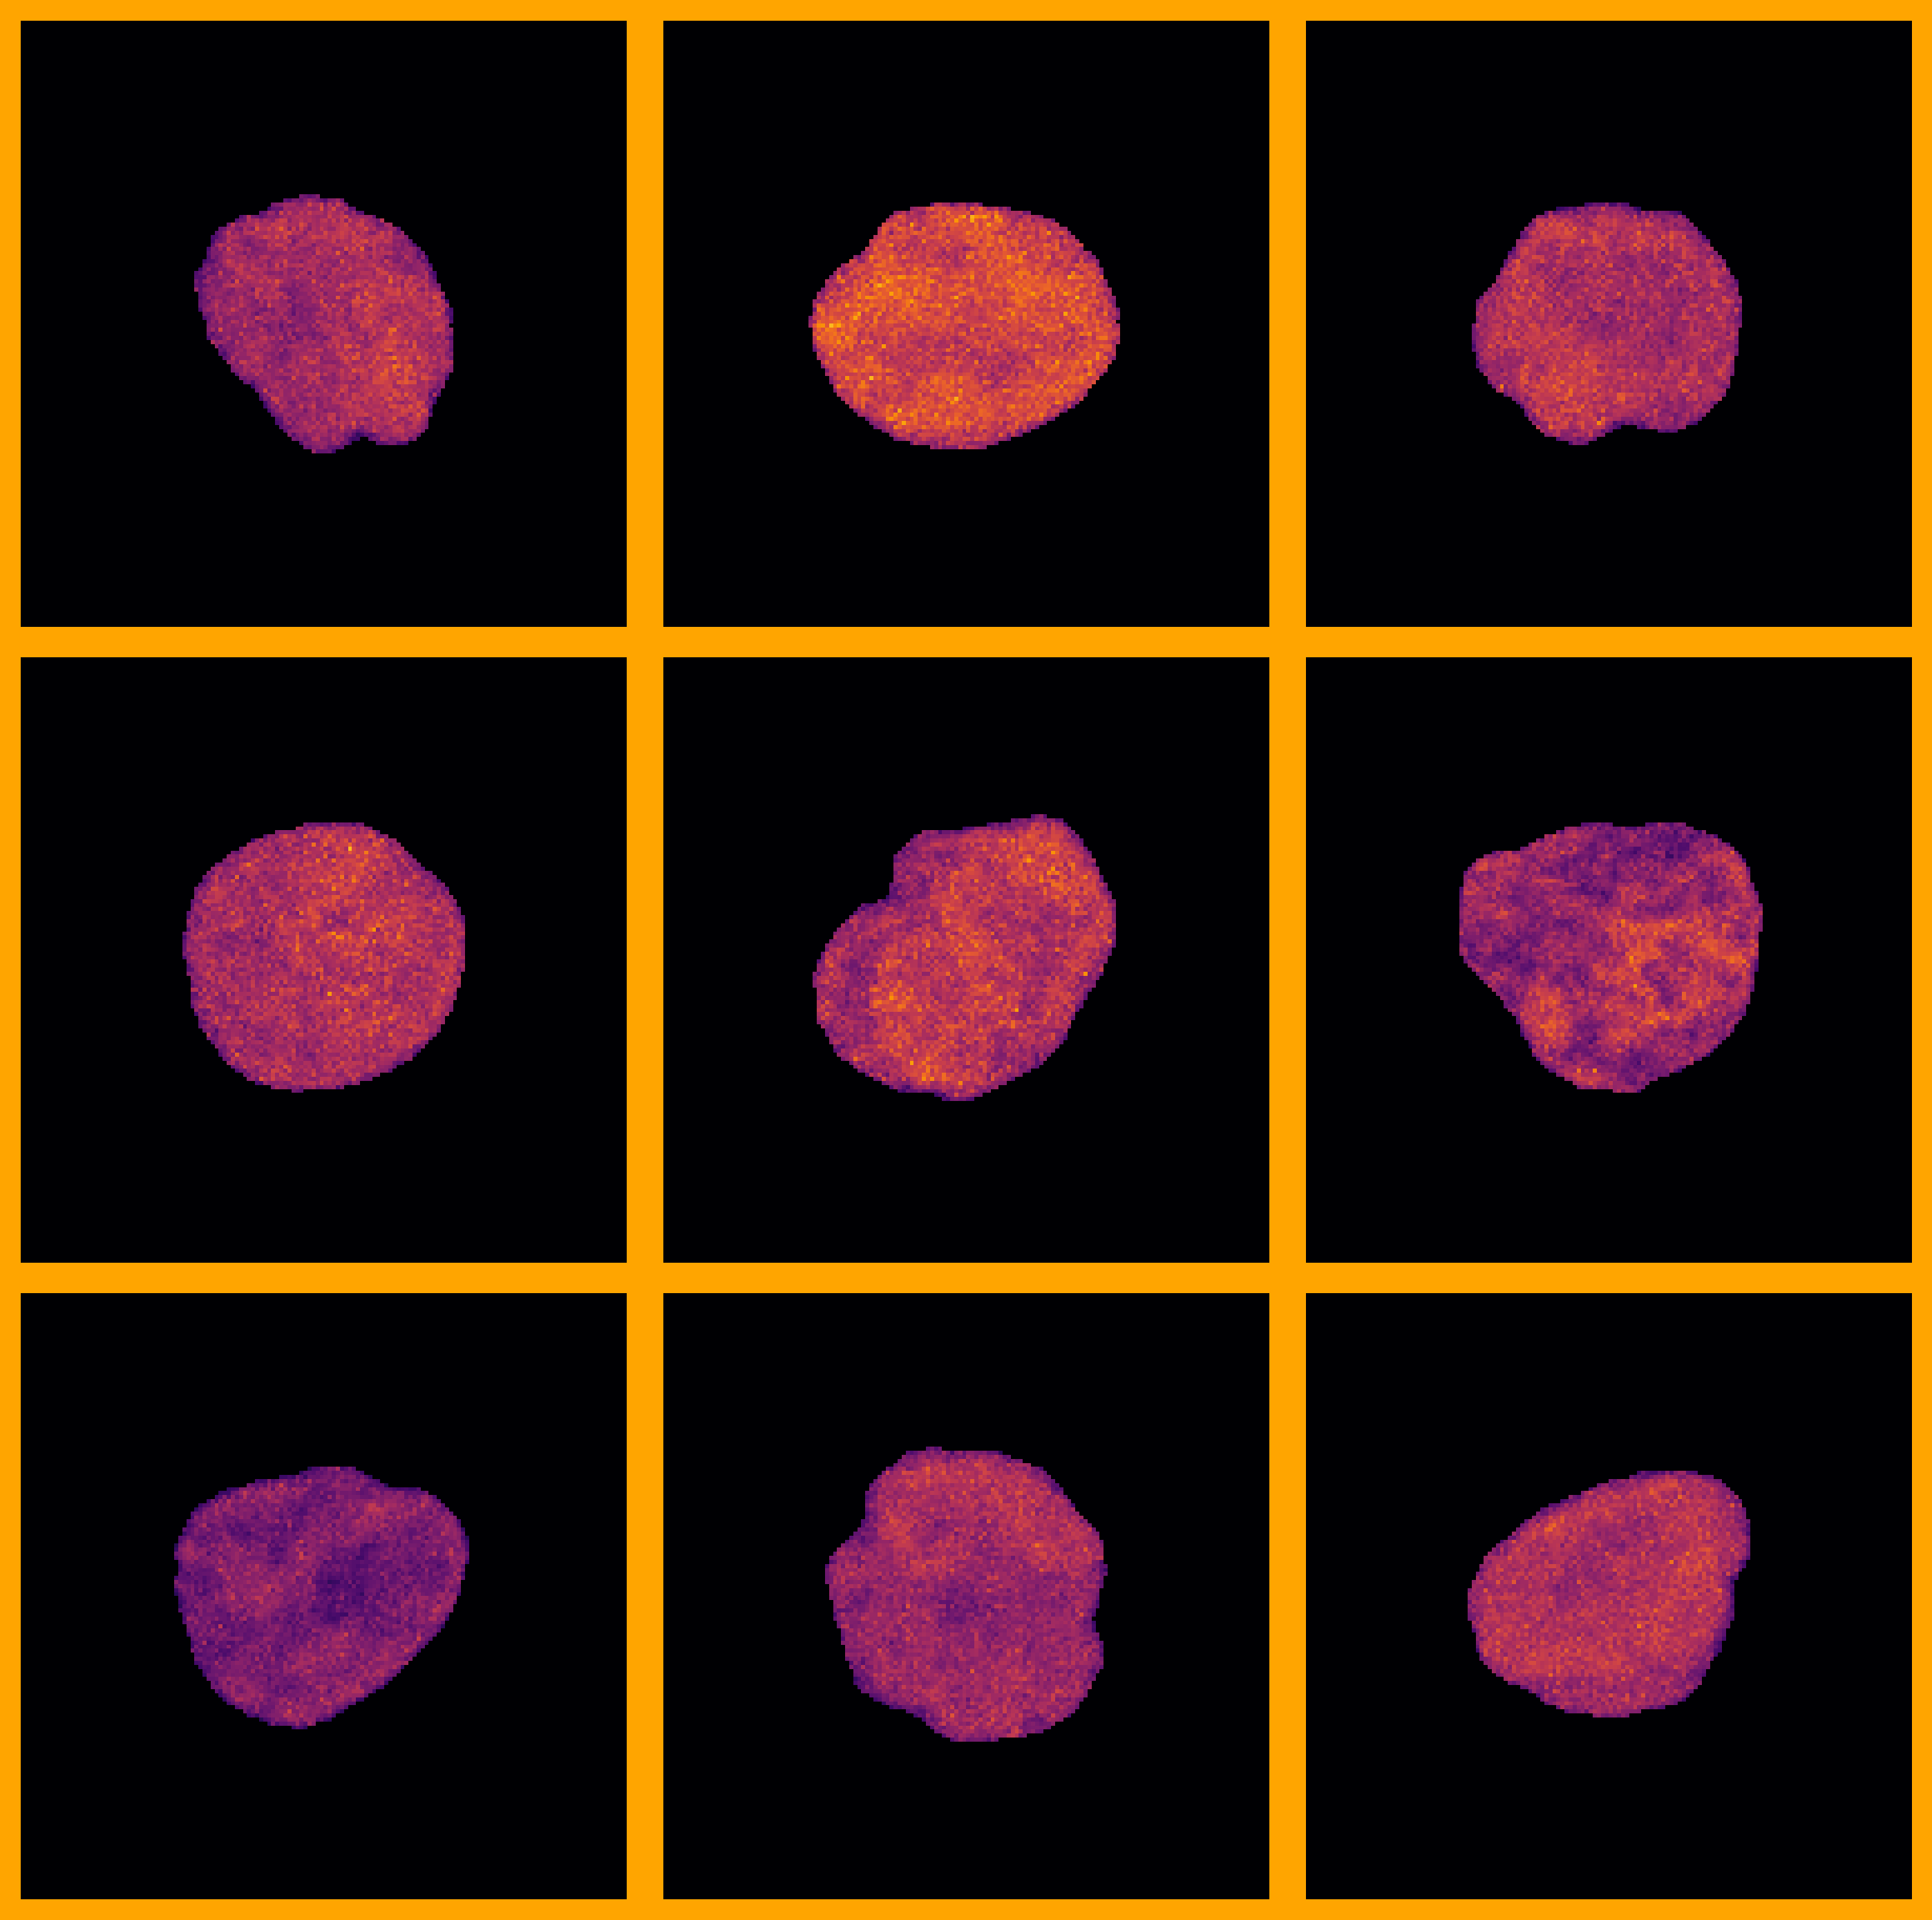

<IPython.core.display.Javascript object>

In [17]:
fig_tp1, ax_tp1 = plot_montage(
    sampled_tp1_images,
    pad_size=150,
    mask_nuclei=True,
    cmap="inferno",
    nrows=3,
    ncols=3,
)
fig_tp1.set_facecolor(color_palette["prior"])

#### During treatment population

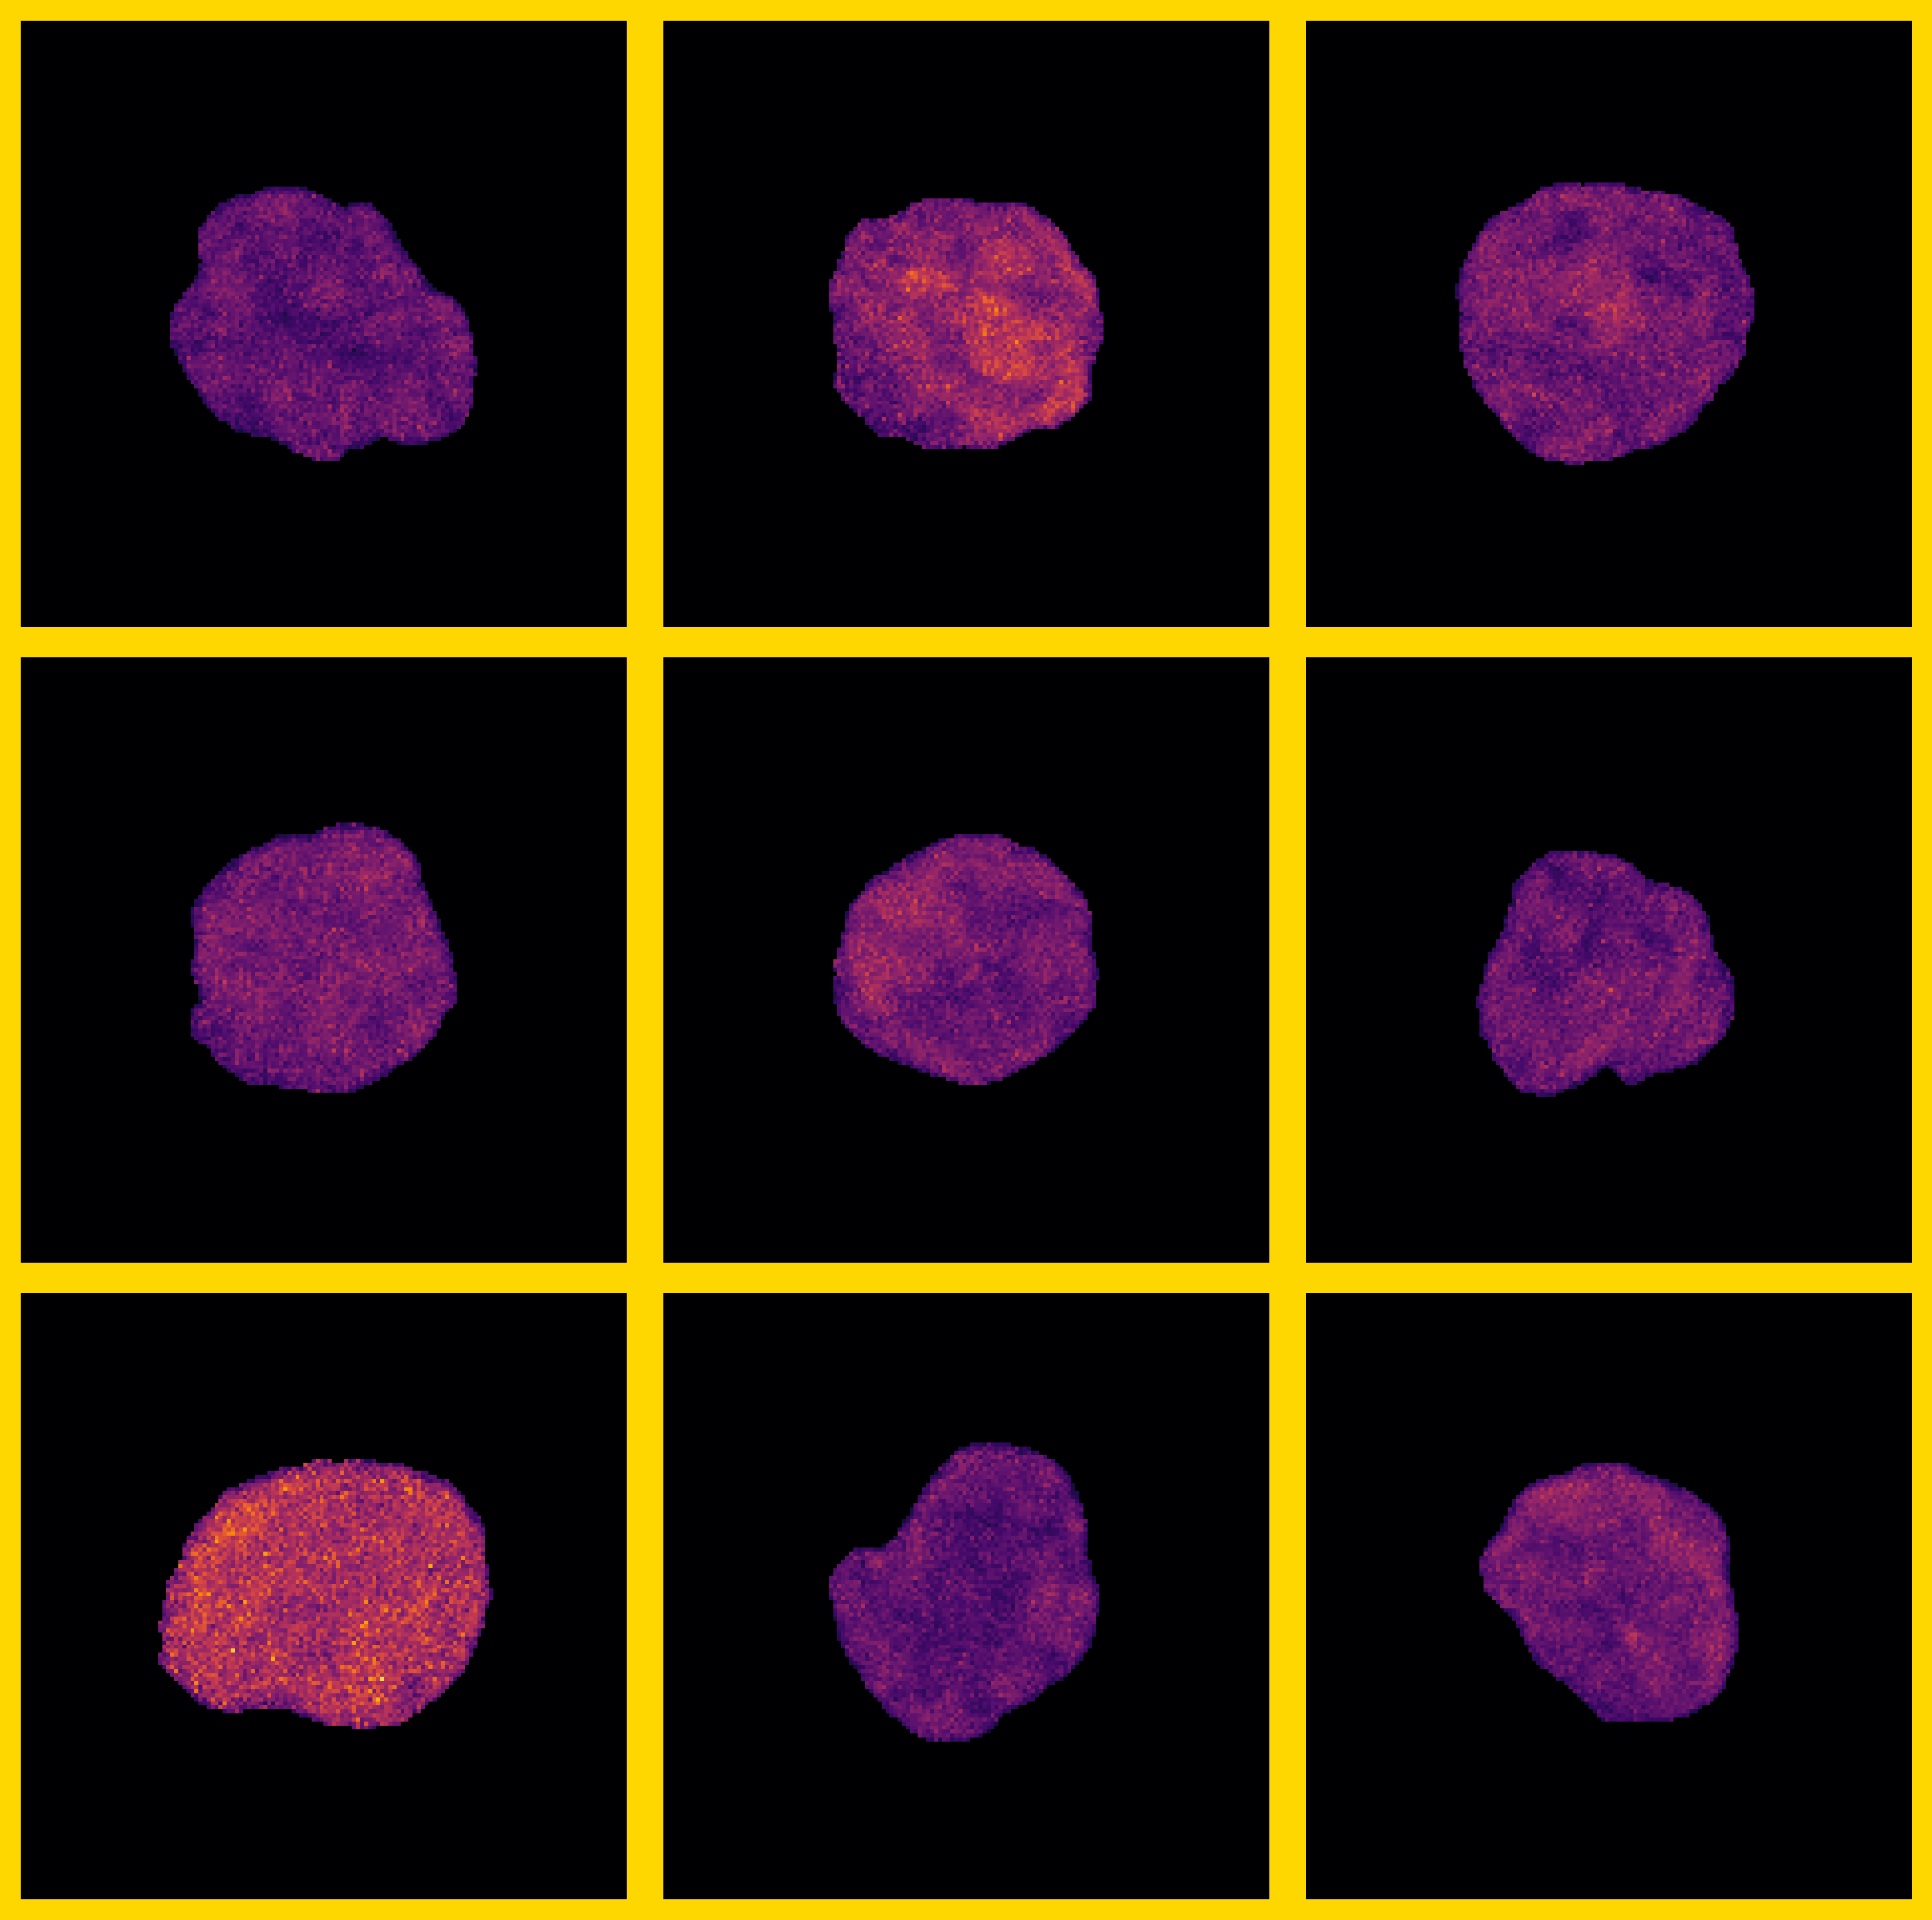

<IPython.core.display.Javascript object>

In [18]:
fig_tp2, ax_tp2 = plot_montage(
    sampled_tp2_images,
    pad_size=150,
    mask_nuclei=True,
    cmap="inferno",
    ncols=3,
    nrows=3,
)
fig_tp2.set_facecolor(color_palette["during"])

#### End of treatment population

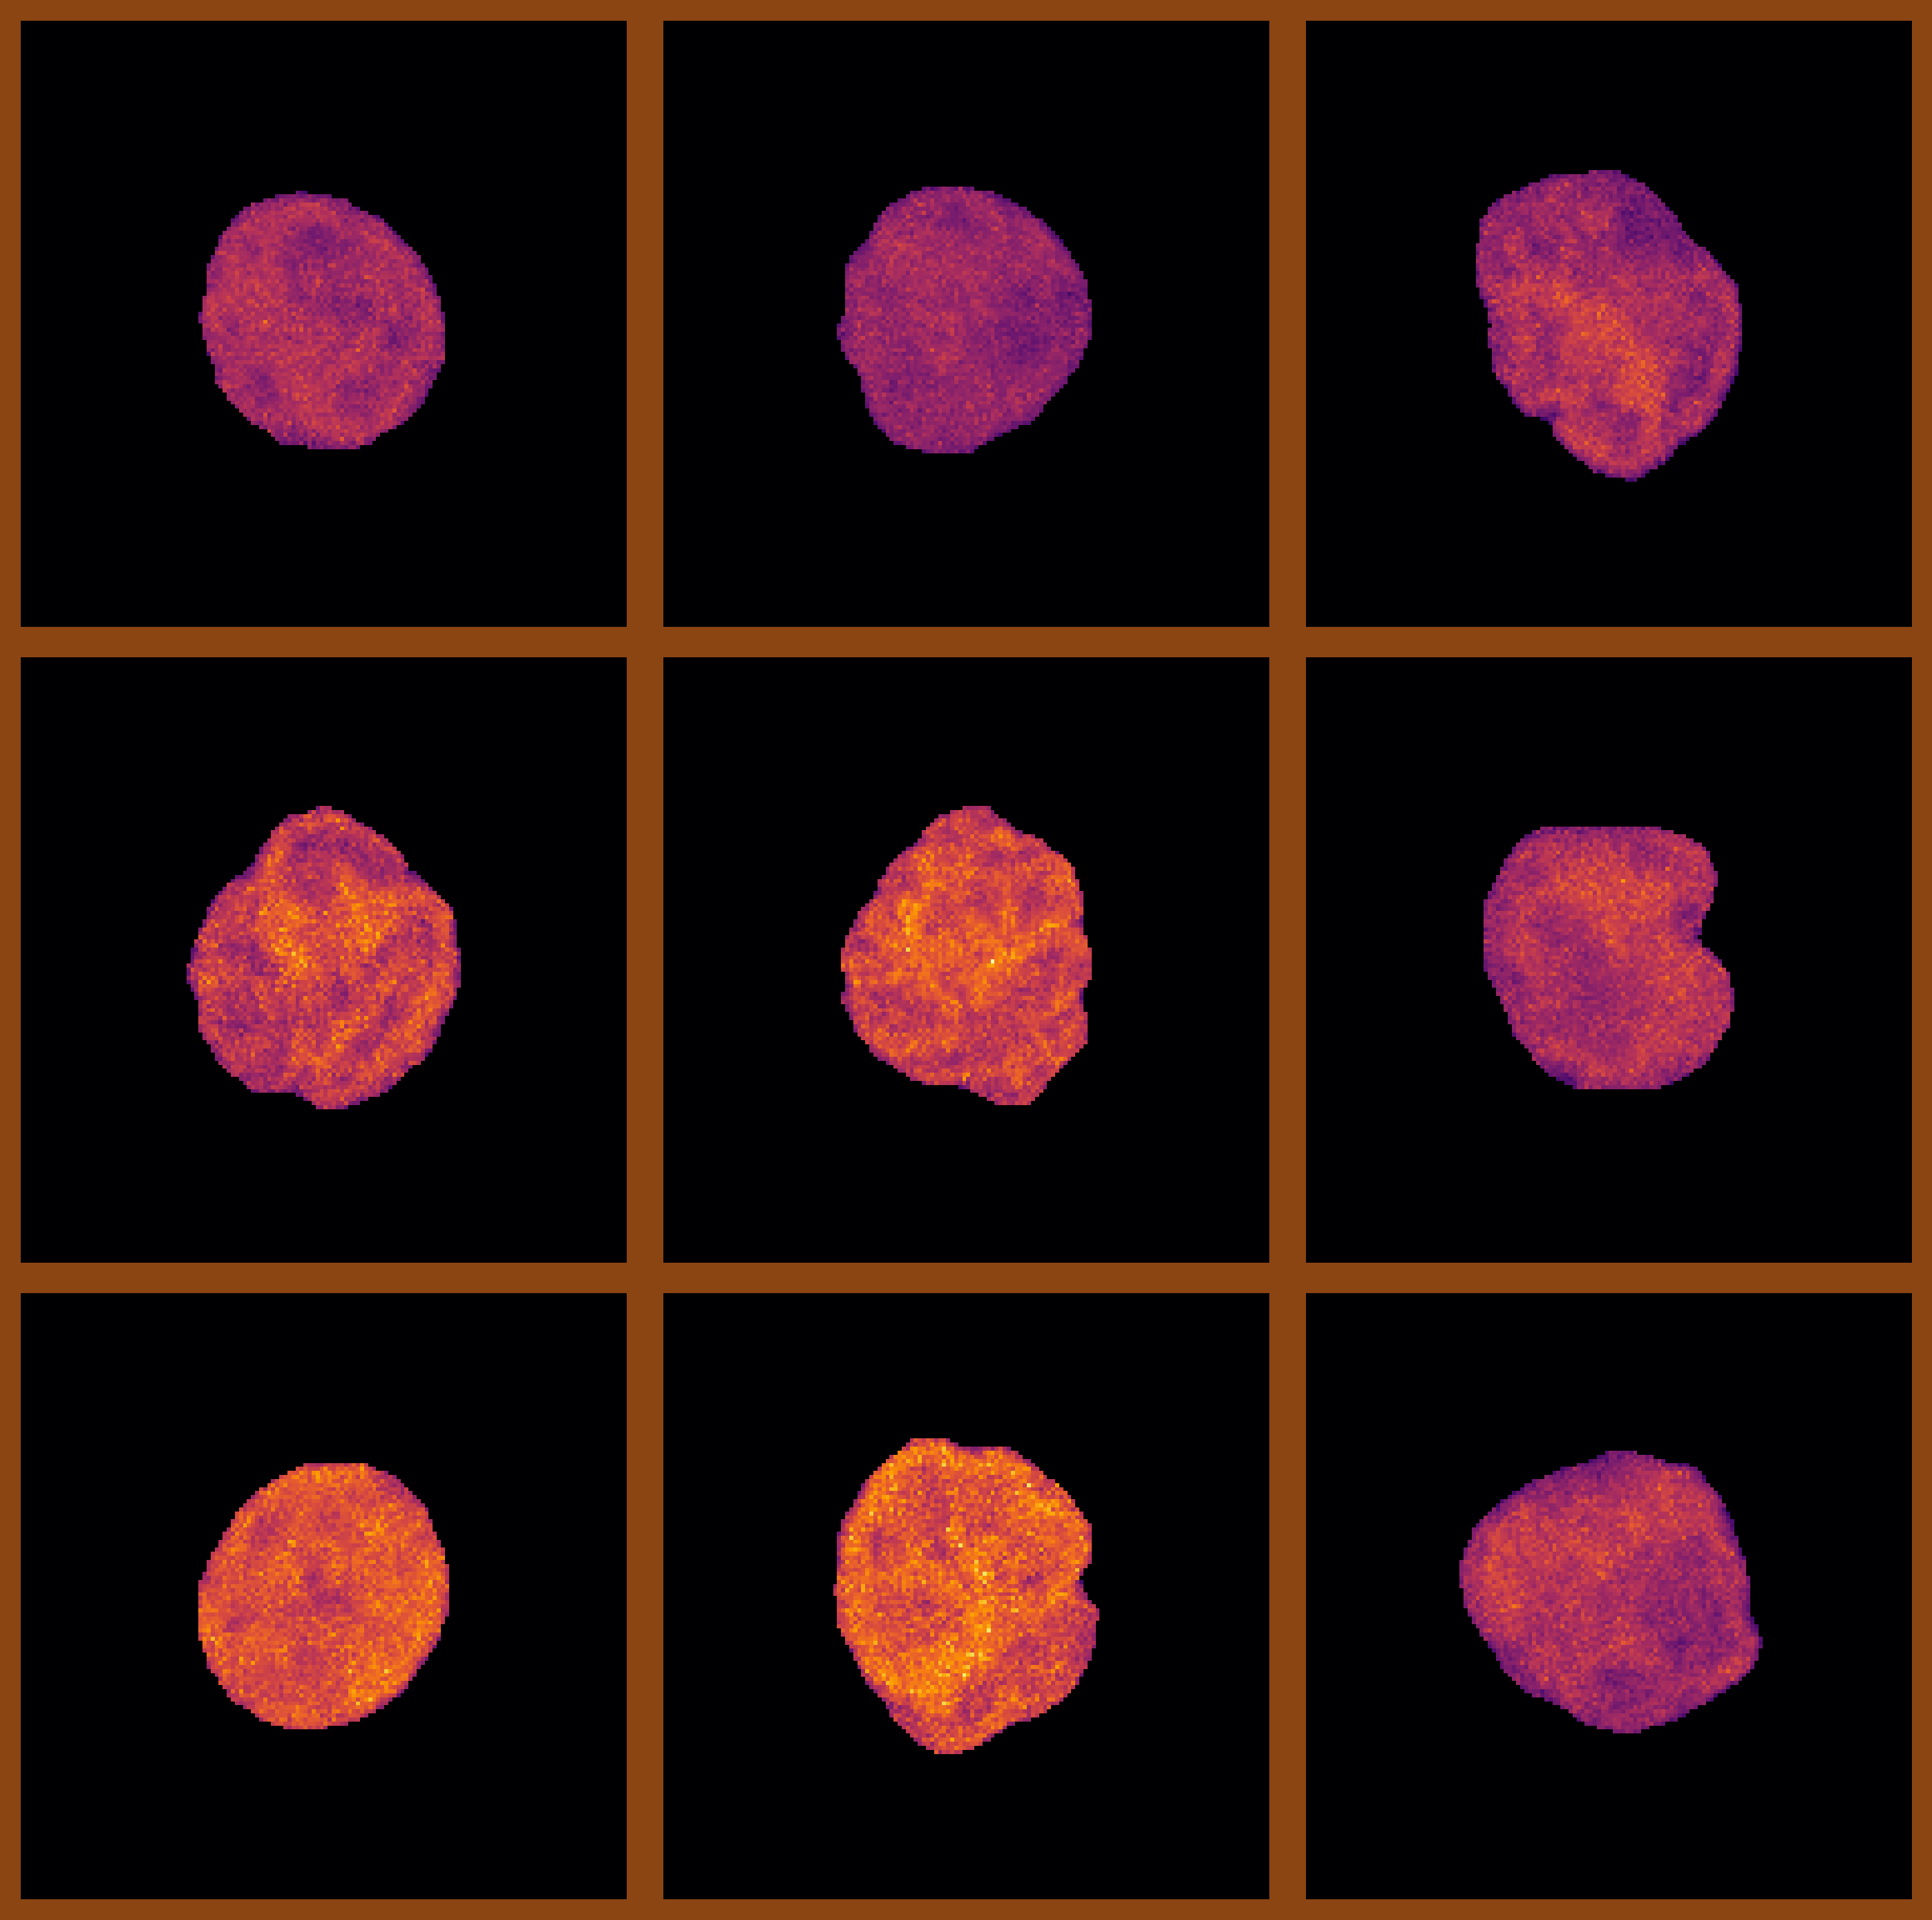

<IPython.core.display.Javascript object>

In [19]:
fig_tp3, ax_tp3 = plot_montage(
    sampled_tp3_images,
    pad_size=150,
    mask_nuclei=True,
    cmap="inferno",
    ncols=3,
    nrows=3,
)
fig_tp3.set_facecolor(color_palette["end"])

---

### 3b. Parametric analysis captures captures differences of PBMCs at different timepoints of the proton therapy treatment

The montage already indicate significant changes in particular between the chrometric pheontype of the PBMCs prior the treatment and the end of it. We will now turn to the assessment of the parametric descriptions of the nuclear phenotypes of the PBMCs at those different timepoints. To this end, we first visualize the data set using a tSNE plot to assess potential large-scale differences between the timepoint populations and individual patient samples.

In [20]:
chrometric_embs = get_tsne_embs(chrometric_data)
chrometric_embs["timepoint"] = np.array(tp_labels)
chrometric_embs["sample"] = np.array(sample_labels)

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

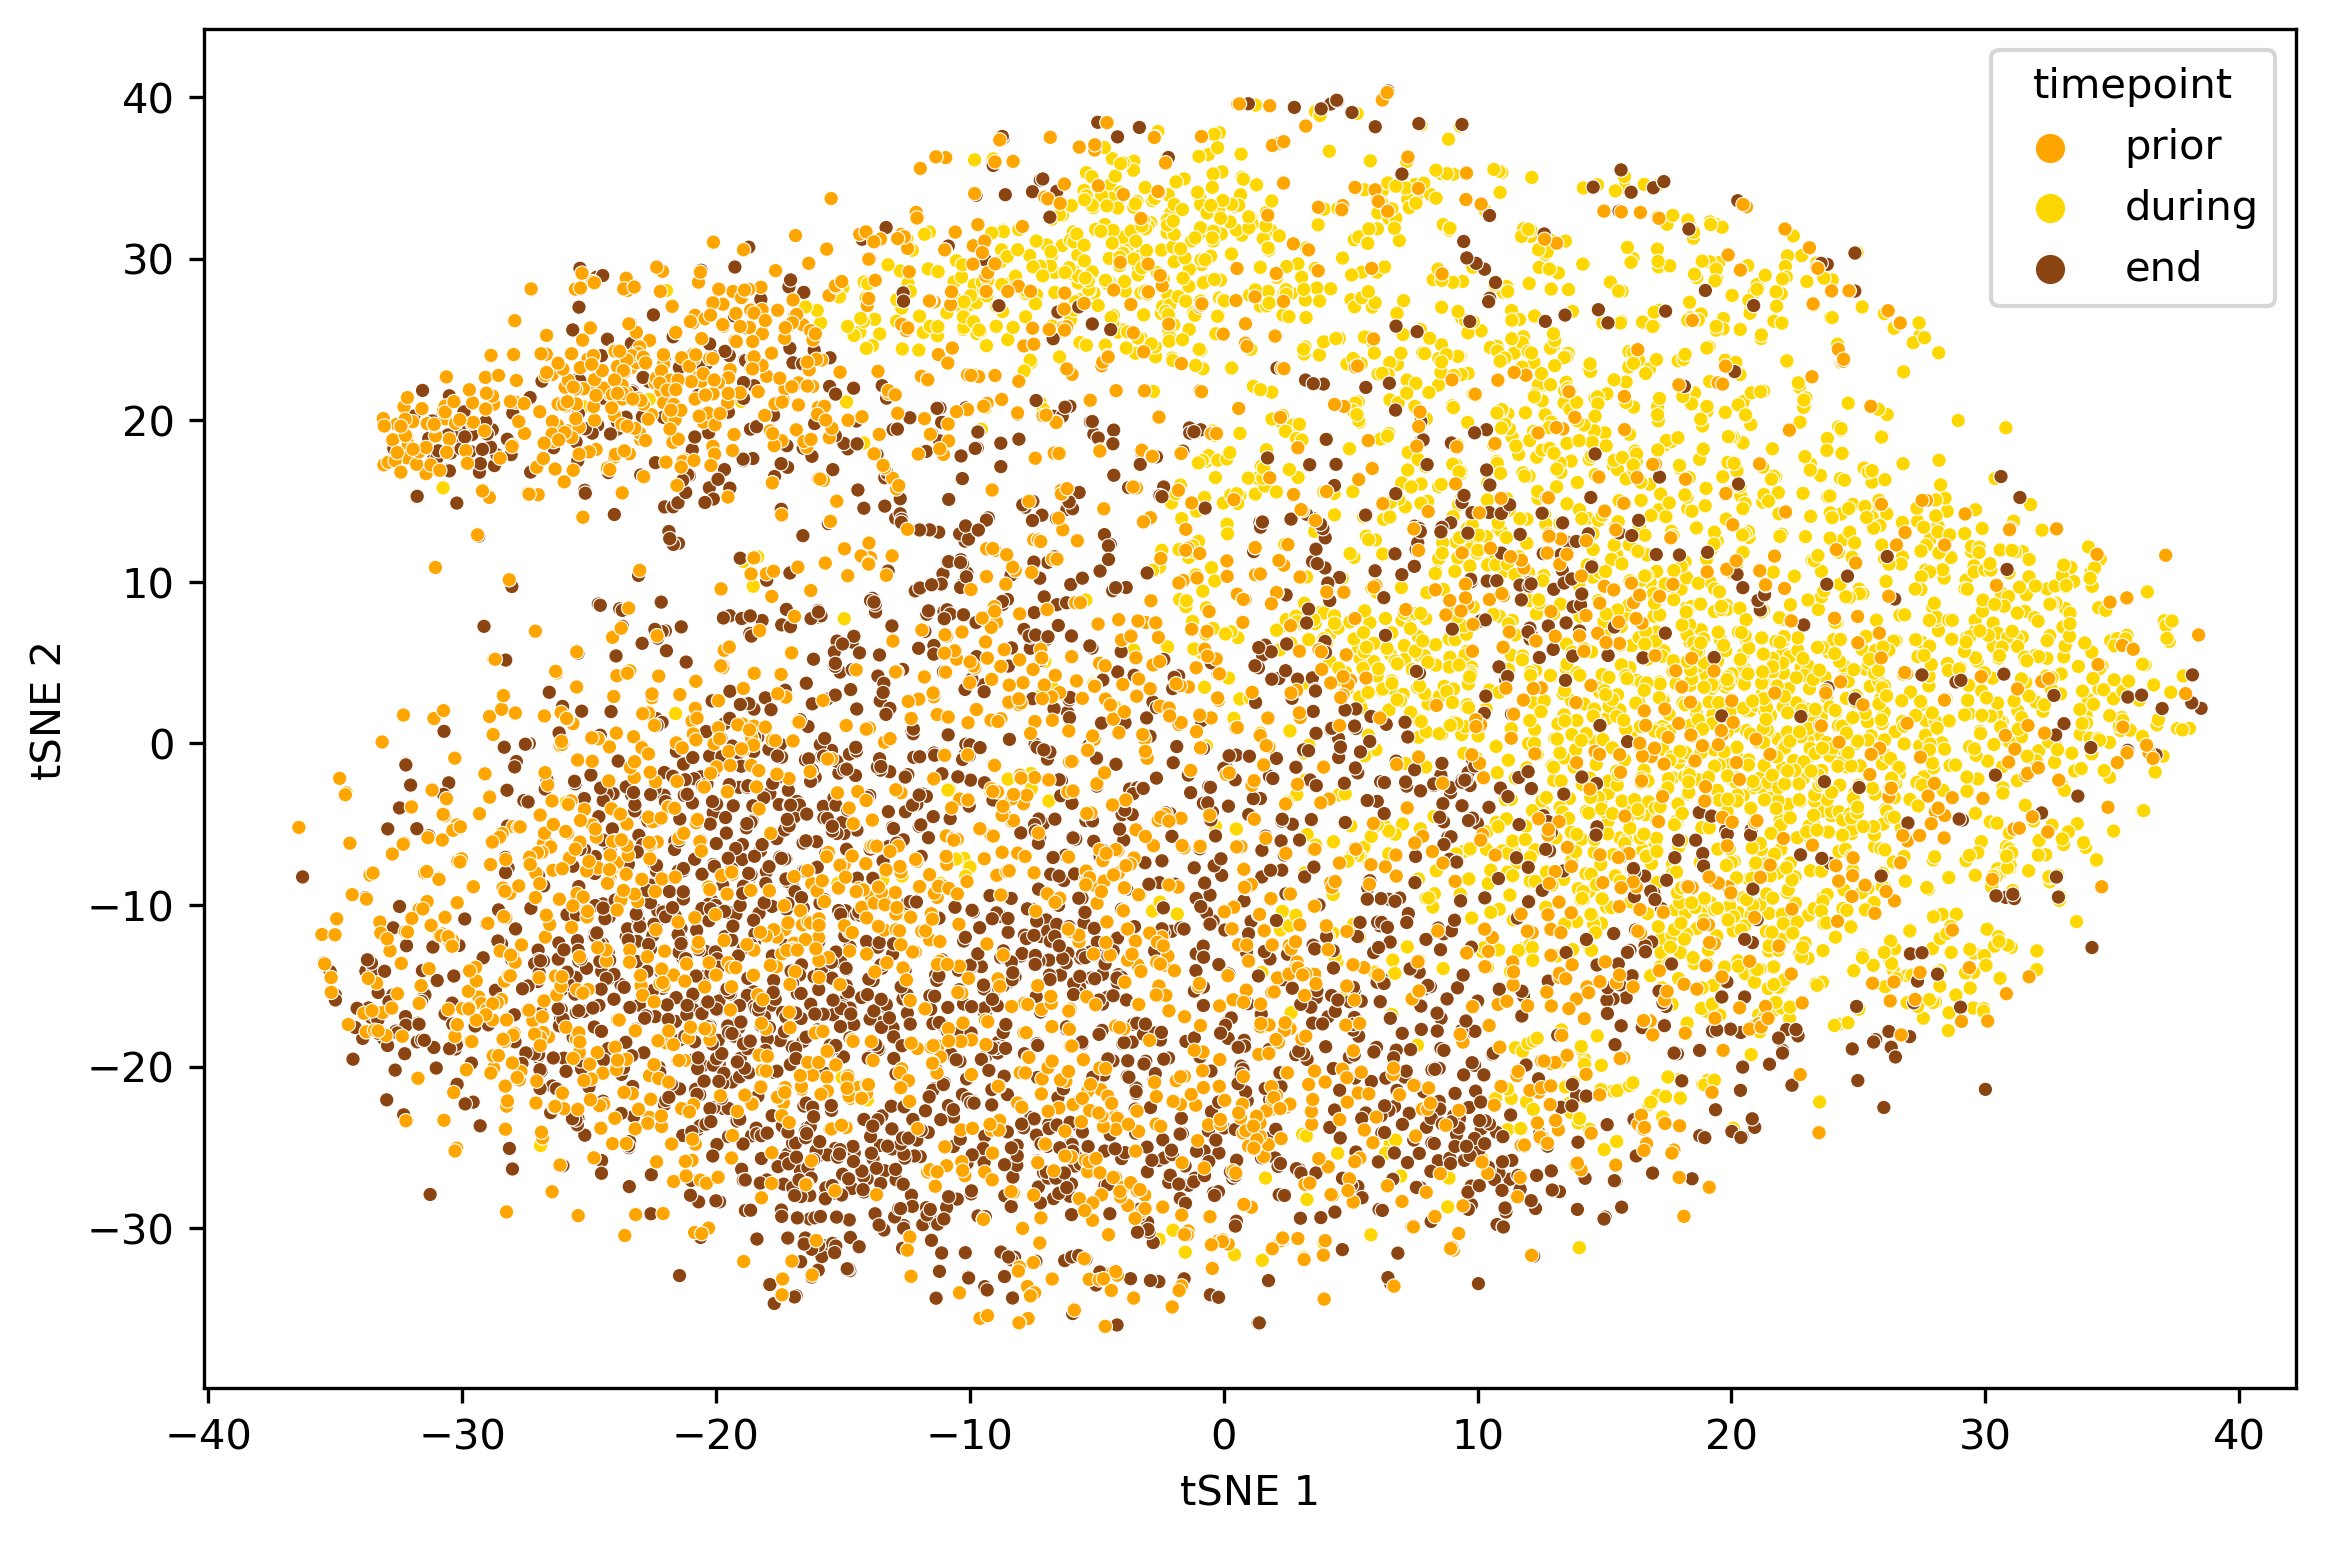

<IPython.core.display.Javascript object>

In [43]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=chrometric_embs,
    x="tSNE 1",
    y="tSNE 2",
    hue="timepoint",
    hue_order=tp_order,
    ax=ax,
    s=12,
    marker="o",
    palette=color_palette,
)
plt.show()

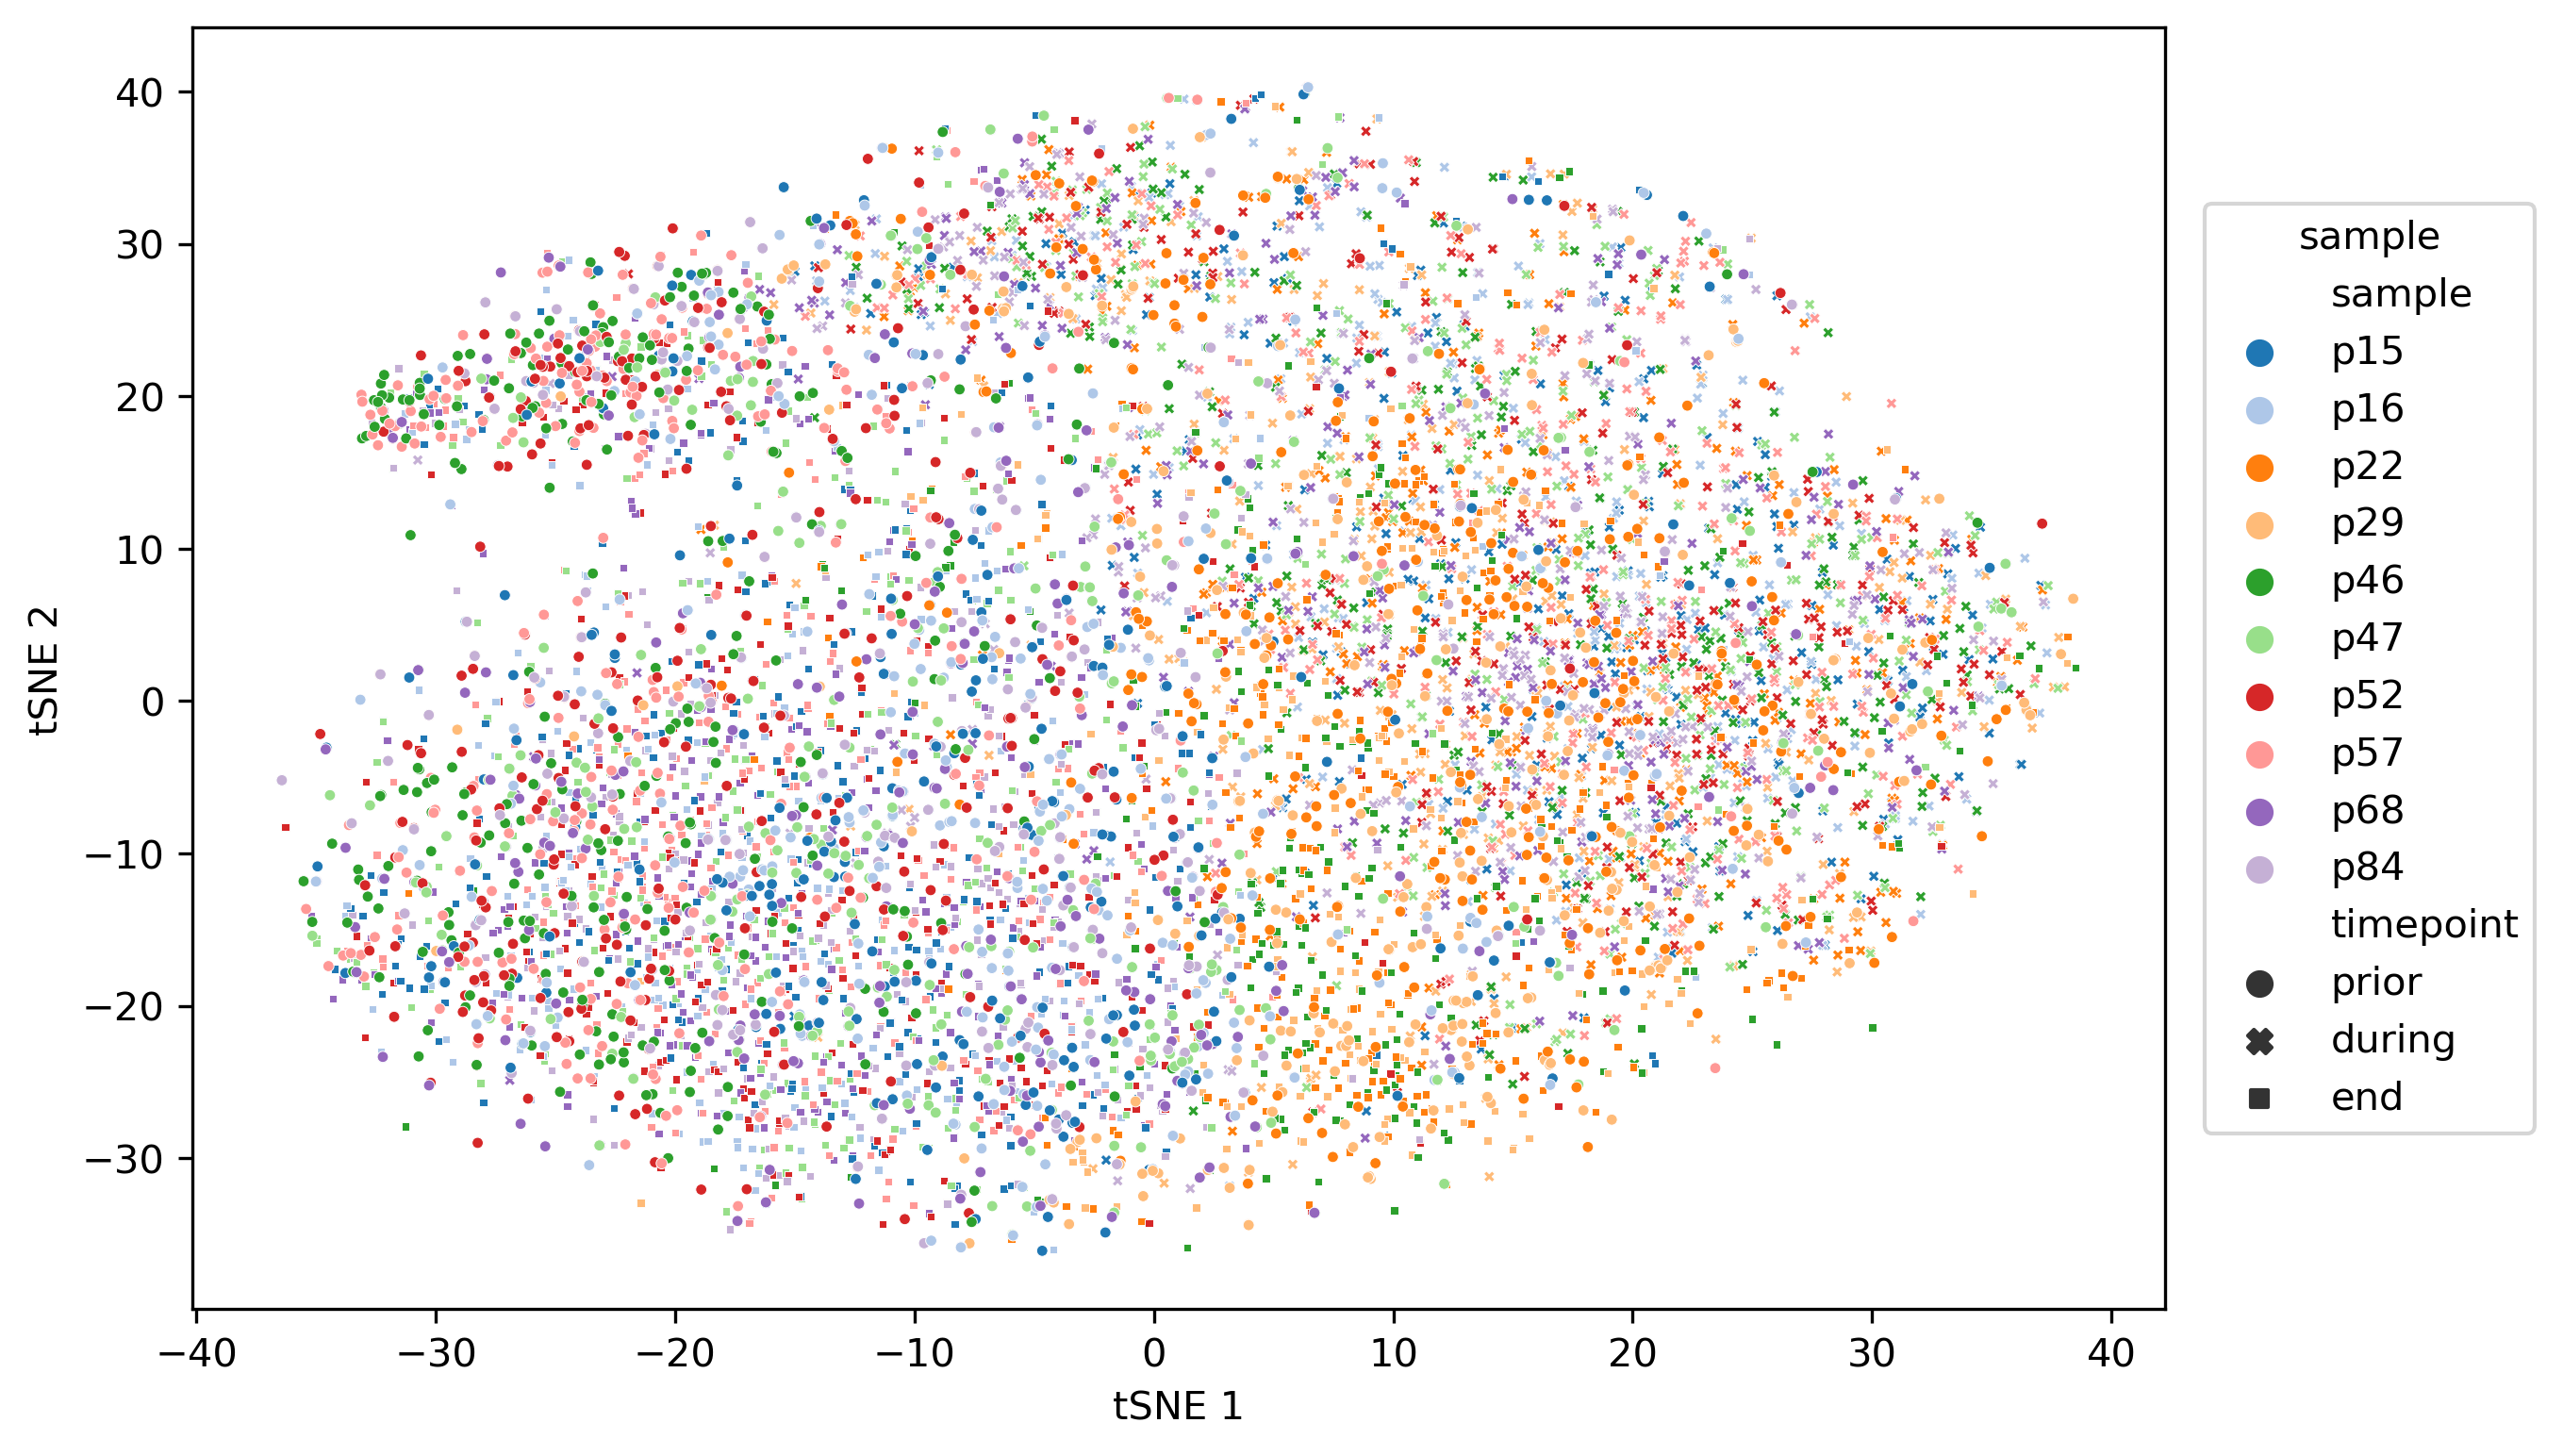

<IPython.core.display.Javascript object>

In [22]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=chrometric_embs,
    x="tSNE 1",
    y="tSNE 2",
    hue="sample",
    style="timepoint",
    style_order=tp_order,
    hue_order=sample_order,
    ax=ax,
    s=8,
    marker="o",
    palette="tab20",
)
plt.legend(
    bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0, title="sample"
)
plt.show()

The tSNE plot also shows that especially the chrometric phenotypes of the PBMCs at the intermediate timepoint of the proton therapy look different from the prior and the end of treatment population.
The patient samples are fairly well mixed with probably the small exception of the PBMCs of P29 and P22.

---

#### Classification of the different cancer types.

To quantify the separability of the timepoint populations using the chrometric phenotypes of the PBMCs of the different cancer patients we perform a 10-fold stratified cross-validation analysis using a RandomForest classifier. The classifier provides a simple non-linear classification model which also yields an importance measure for the individual chrometric features indicating which ones are most different between the three populations.

##### Nuclei split

At first we will split the data randomly on a nuclei-basis, i.e. nuclei of the same patient will be likely included in both the training and the test sets.

In [23]:
rfc = RandomForestClassifier(
    n_estimators=500, n_jobs=10, random_state=seed, class_weight="balanced"
)

<IPython.core.display.Javascript object>

In [24]:
tp_cv_conf_mtx_nuclei = get_cv_conf_mtx(
    estimator=rfc,
    features=chrometric_data,
    labels=tp_labels,
    scale_features=False,
    n_folds=10,
    order=tp_order,
)
normalized_cv_conf_mtx_nuclei = tp_cv_conf_mtx_nuclei.divide(
    tp_cv_conf_mtx_nuclei.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

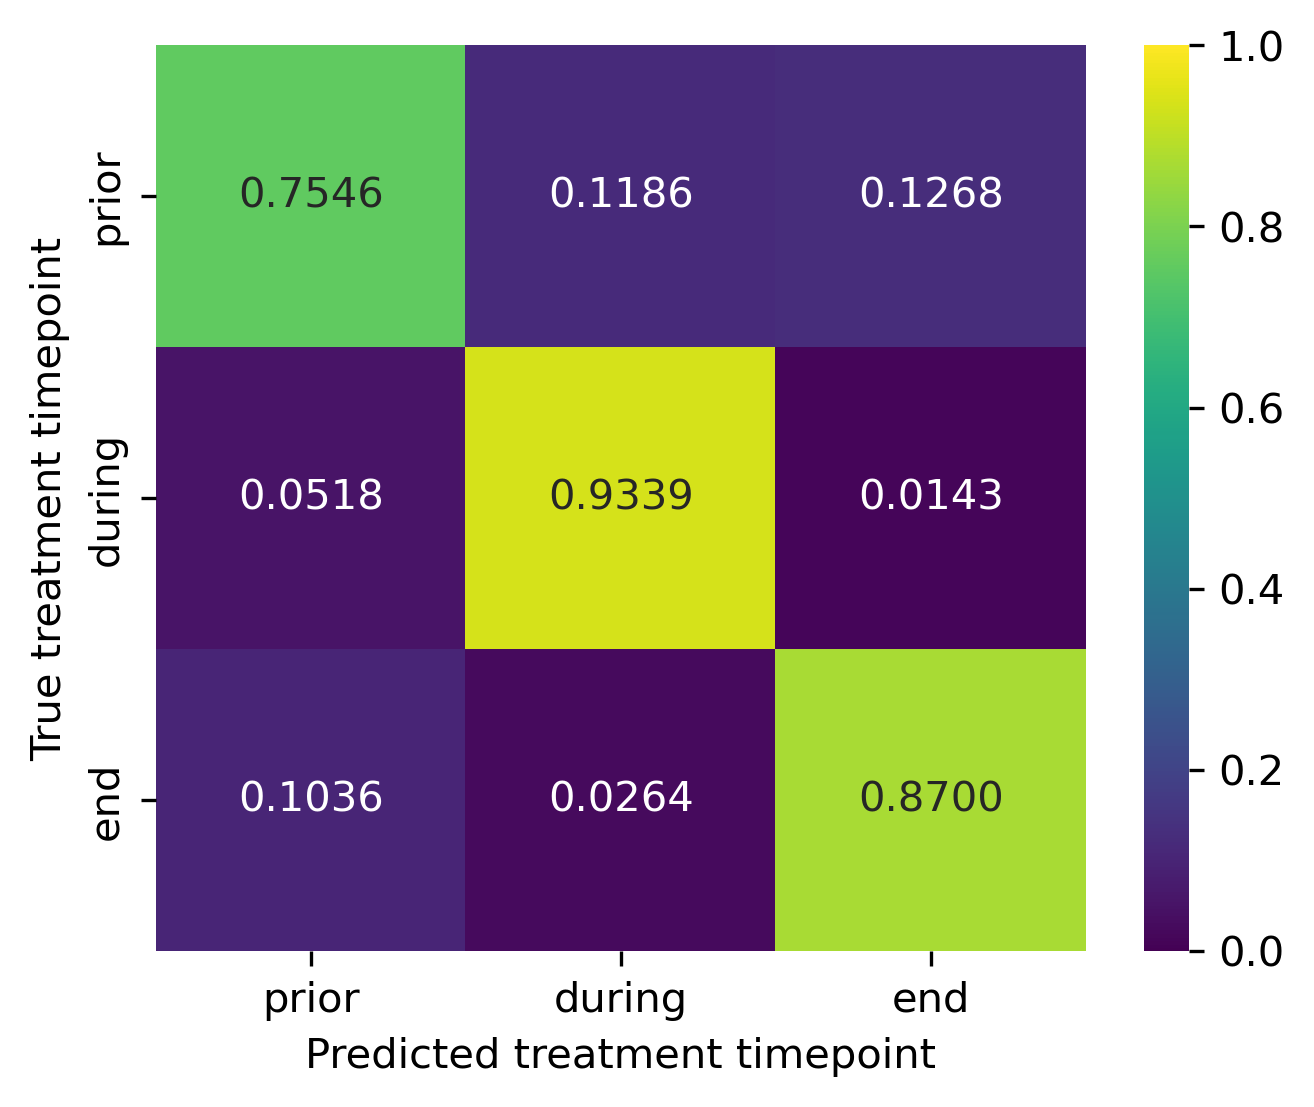

<IPython.core.display.Javascript object>

In [25]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    normalized_cv_conf_mtx_nuclei,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted treatment timepoint")
ax.set_ylabel("True treatment timepoint")
plt.show()

The classifier is able to accurately distinguish nuclei from the timepoint populations. The confusion matrix also shows that the classifier does particularly better on distinguishing PBMCs from the during the treatment from the other two timepoints, where those are more often confused for one another. Nonetheless, all timepoints seem to feature fairly different chrometric cell state distribution of the PBMCs.

To further assess the similarity of the different timepoint distribution and their linear separability we use a linear discriminant analysis.

In [26]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda_tp_cv_conf_mtx_nuclei = get_cv_conf_mtx(
    estimator=lda,
    features=chrometric_data,
    labels=tp_labels,
    scale_features=True,
    n_folds=10,
    order=tp_order,
)
lda_normalized_cv_conf_mtx_nuclei = lda_tp_cv_conf_mtx_nuclei.divide(
    lda_tp_cv_conf_mtx_nuclei.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

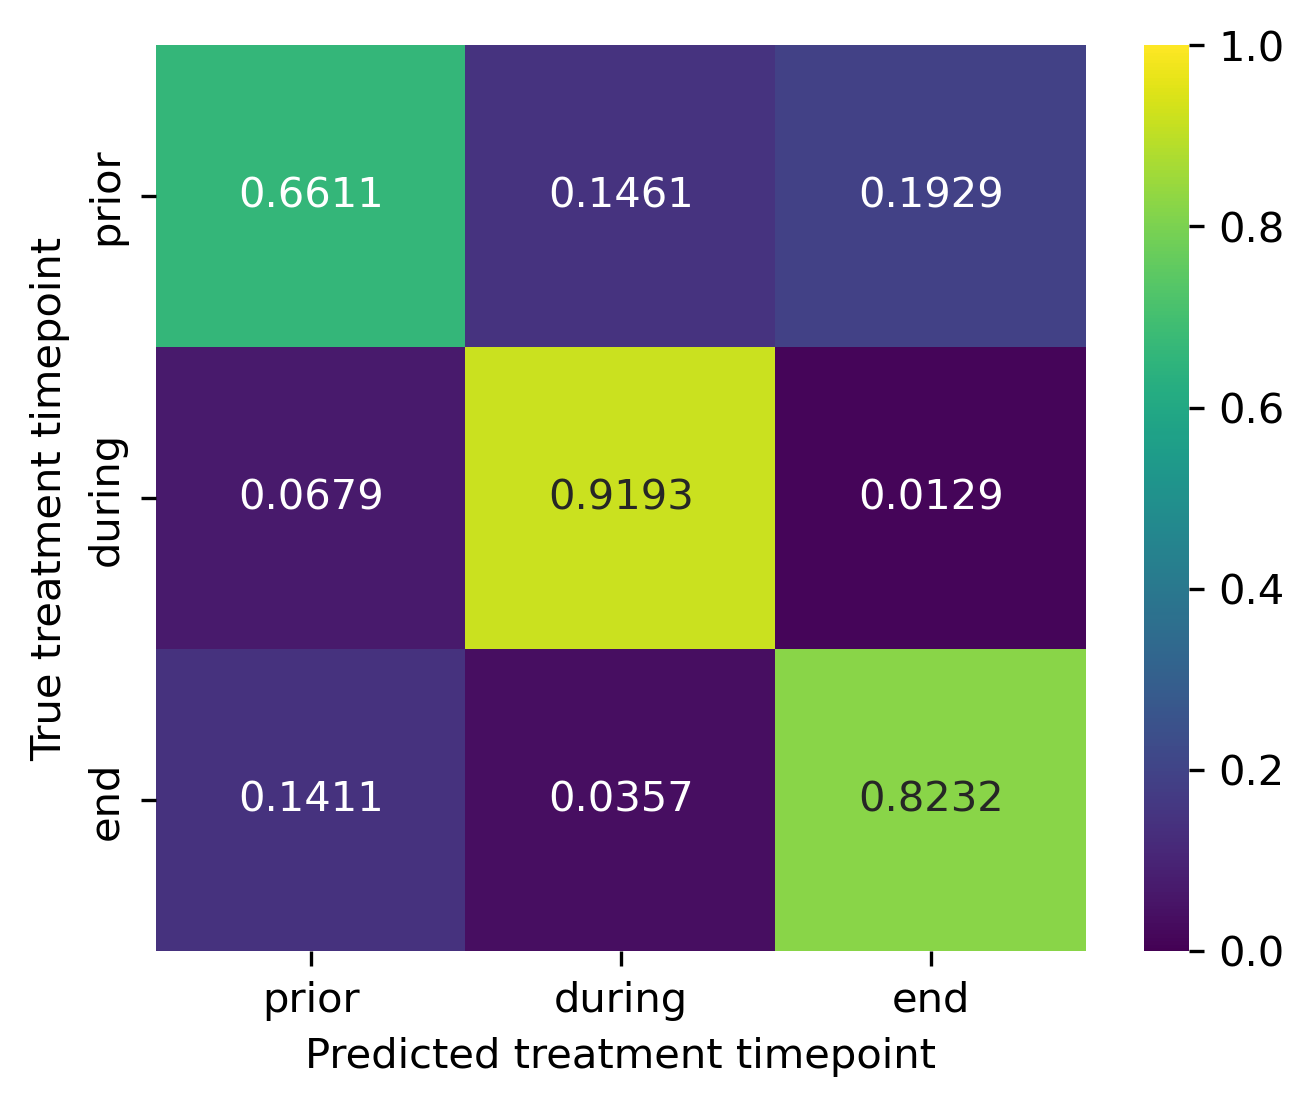

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    lda_normalized_cv_conf_mtx_nuclei,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted treatment timepoint")
ax.set_ylabel("True treatment timepoint")
plt.show()

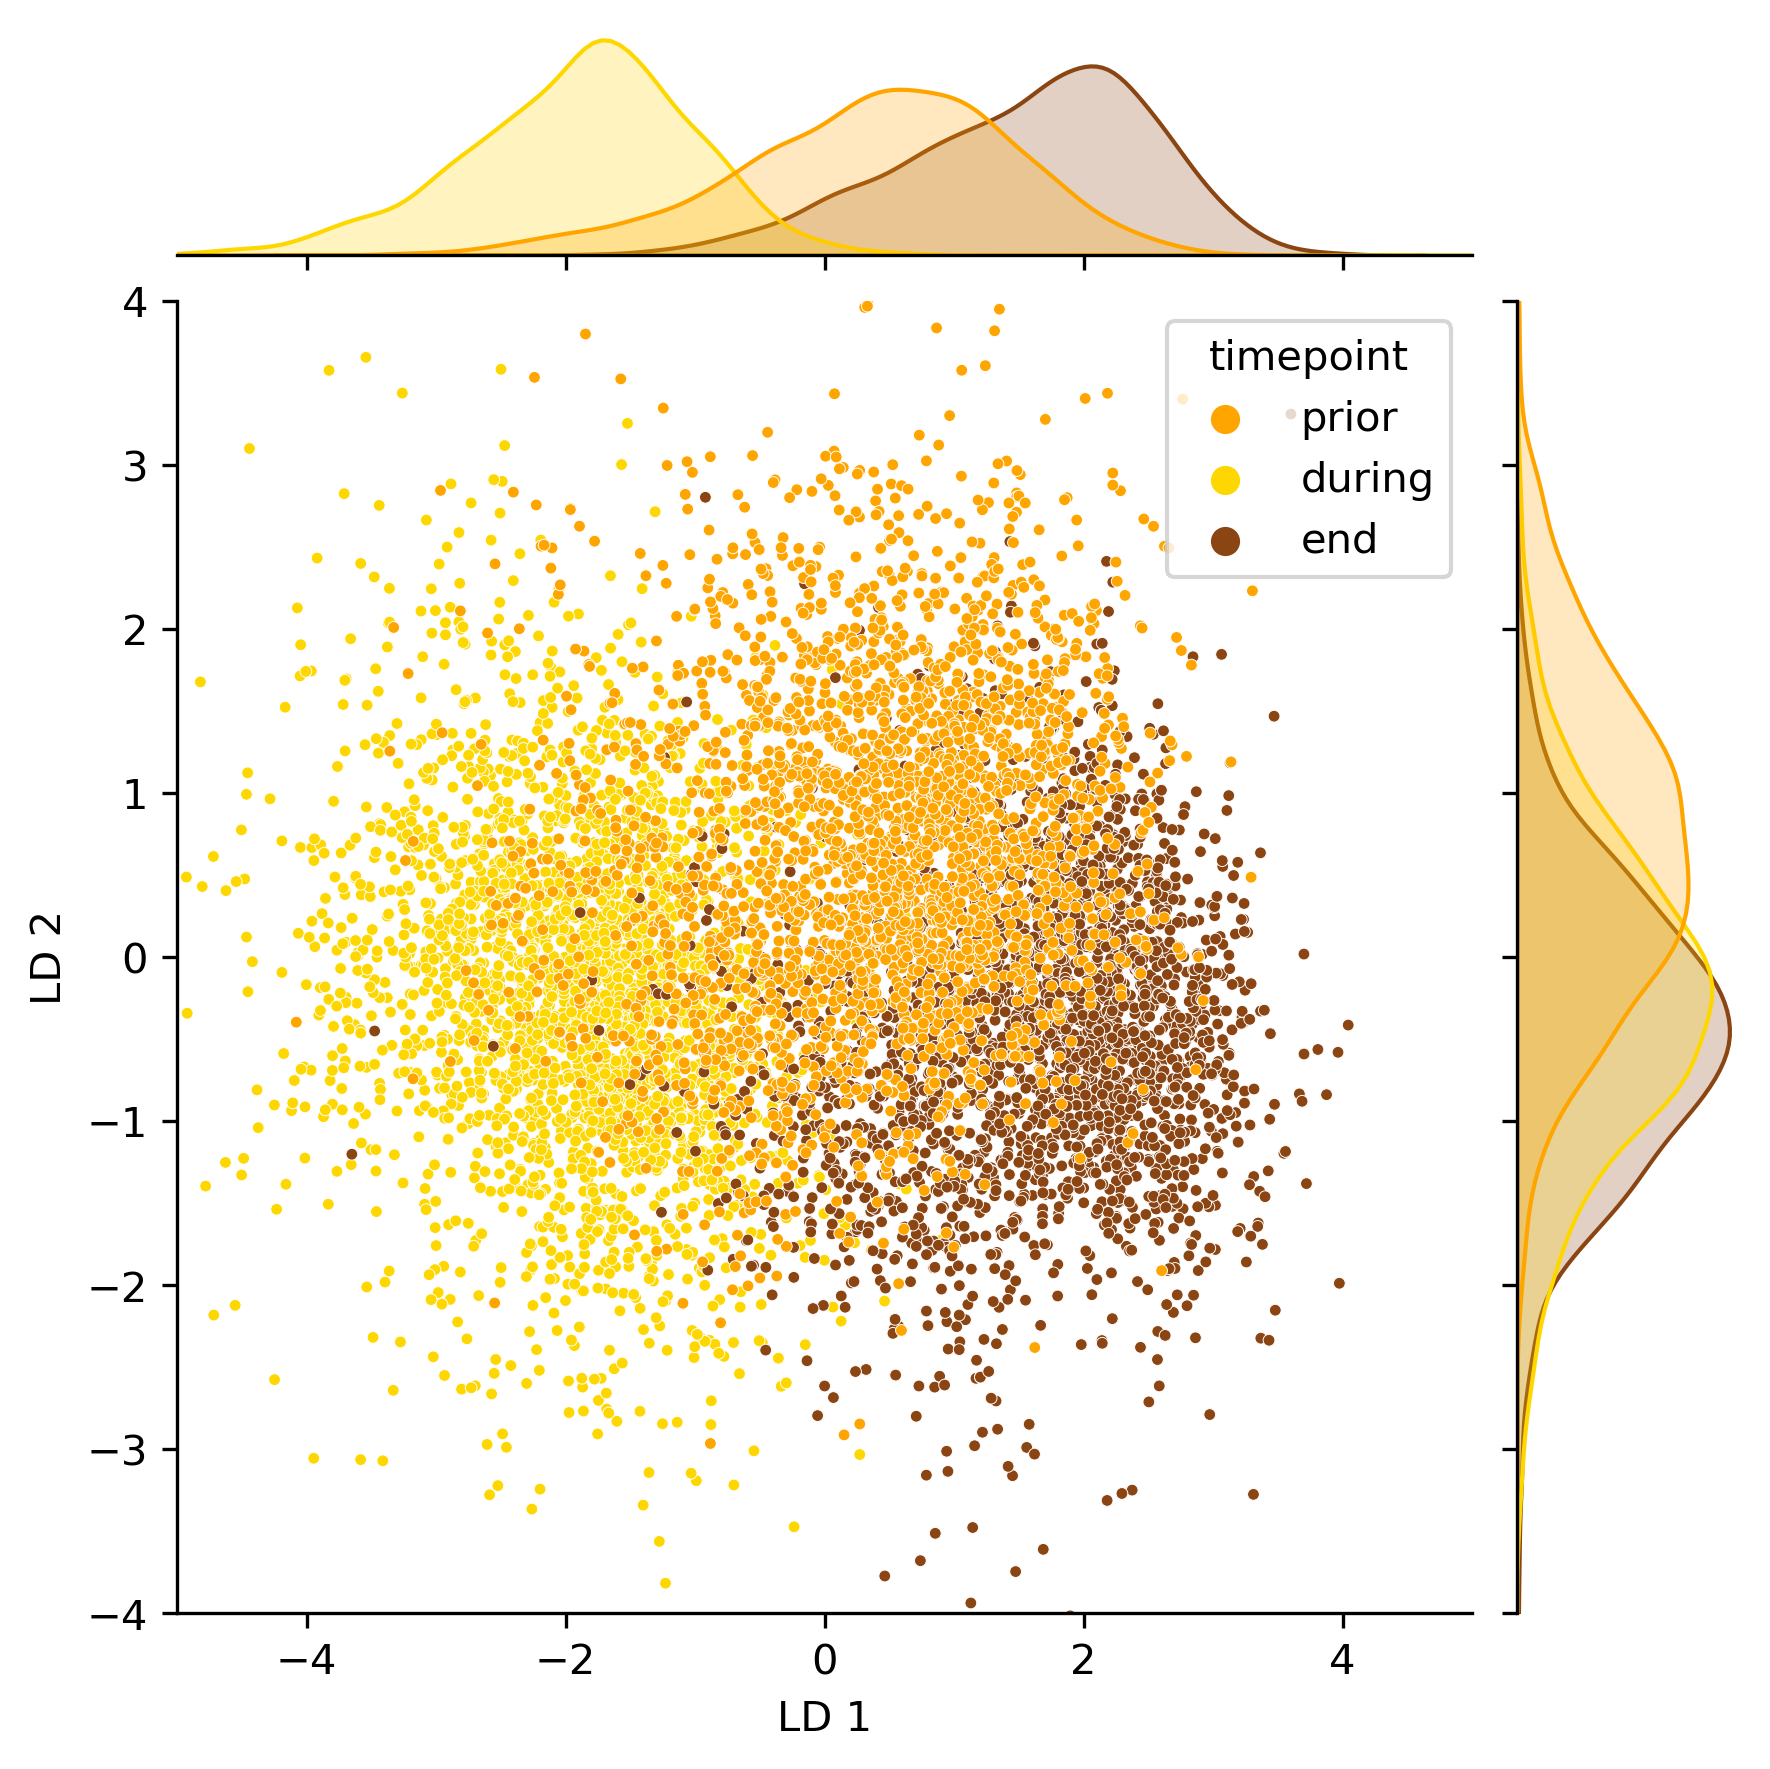

<IPython.core.display.Javascript object>

In [44]:
lda_transformed = pd.DataFrame(
    lda.fit(chrometric_data, tp_labels).transform(chrometric_data),
    columns=["LD 1", "LD 2"],
    index=chrometric_data.index,
)
lda_transformed["timepoint"] = np.array(tp_labels)
lda_transformed["sample"] = np.array(sample_labels)
g = sns.jointplot(
    data=lda_transformed,
    x="LD 1",
    y="LD 2",
    hue="timepoint",
    s=8,
    hue_order=tp_order,
    height=6,
    palette=color_palette,
    xlim=[-5, 5],
    ylim=[-4, 4],
)

In [29]:
np.sum(np.abs(lda_transformed.loc[:, "LD 1"]) > 5) + np.sum(
    np.abs(lda_transformed.loc[:, "LD 2"]) > 4
)

25

<IPython.core.display.Javascript object>

The above LDA plot suggests in addition to the confusion matrix that the indeed the population of the PBMCs prior and the end of the treatment of the proton therapy look more alike compared to those during the treatment.

Note that in the above plot 6 outlier sample is excluded for better visualization of the population differences.

---
#### Patient split


While the previous analysis assess the level of differences of the chrometric phenotypes of the PBMCs between the different treatment timepoints, the classifier can make use of patient specific characteristics during the classification. In a diagnostic use case such information would not be available. To evaluate how well a classifier would be able to predict for unseen patient the corresponding treatment timepoint simply based on the chrometric phenotypes of the PBMCs, we also assess the class separability using a stratified 5-fold patient-cross-validation approach. Thereby at each iteration 1-2 of the patients of each timepoint are hold out for the test set.

In [30]:
tp_cv_conf_mtx_patient = get_cv_conf_mtx(
    estimator=rfc,
    features=chrometric_data,
    labels=tp_labels,
    groups=sample_labels,
    scale_features=False,
    n_folds=5,
    order=tp_order,
)
normalized_cv_conf_mtx_patient = tp_cv_conf_mtx_patient.divide(
    tp_cv_conf_mtx_patient.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

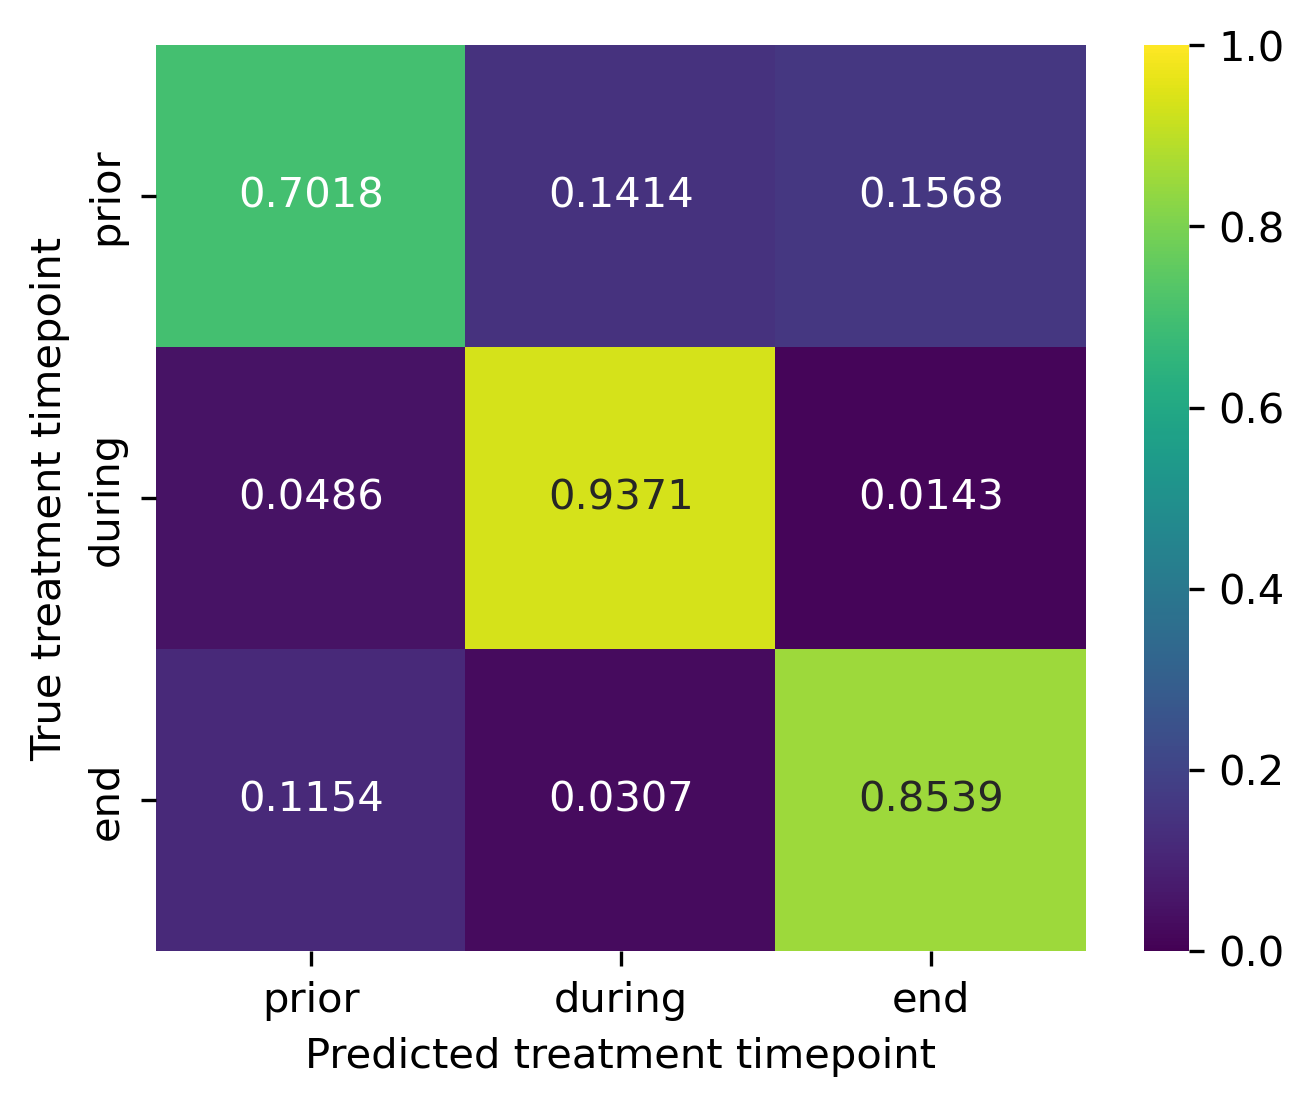

<IPython.core.display.Javascript object>

In [31]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    normalized_cv_conf_mtx_patient,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted treatment timepoint")
ax.set_ylabel("True treatment timepoint")
plt.show()

In [32]:
groupkfold = StratifiedGroupKFold(n_splits=10)
cv_bacs = cross_val_score(
    rfc,
    cv=groupkfold,
    X=chrometric_data,
    y=tp_labels,
    groups=sample_labels,
    scoring="balanced_accuracy",
    n_jobs=10,
)
print("Balanced accuracy: {} (+/- {})".format(np.mean(cv_bacs), np.std(cv_bacs)))

Balanced accuracy: 0.8320238095238096 (+/- 0.11626199252992989)


<IPython.core.display.Javascript object>

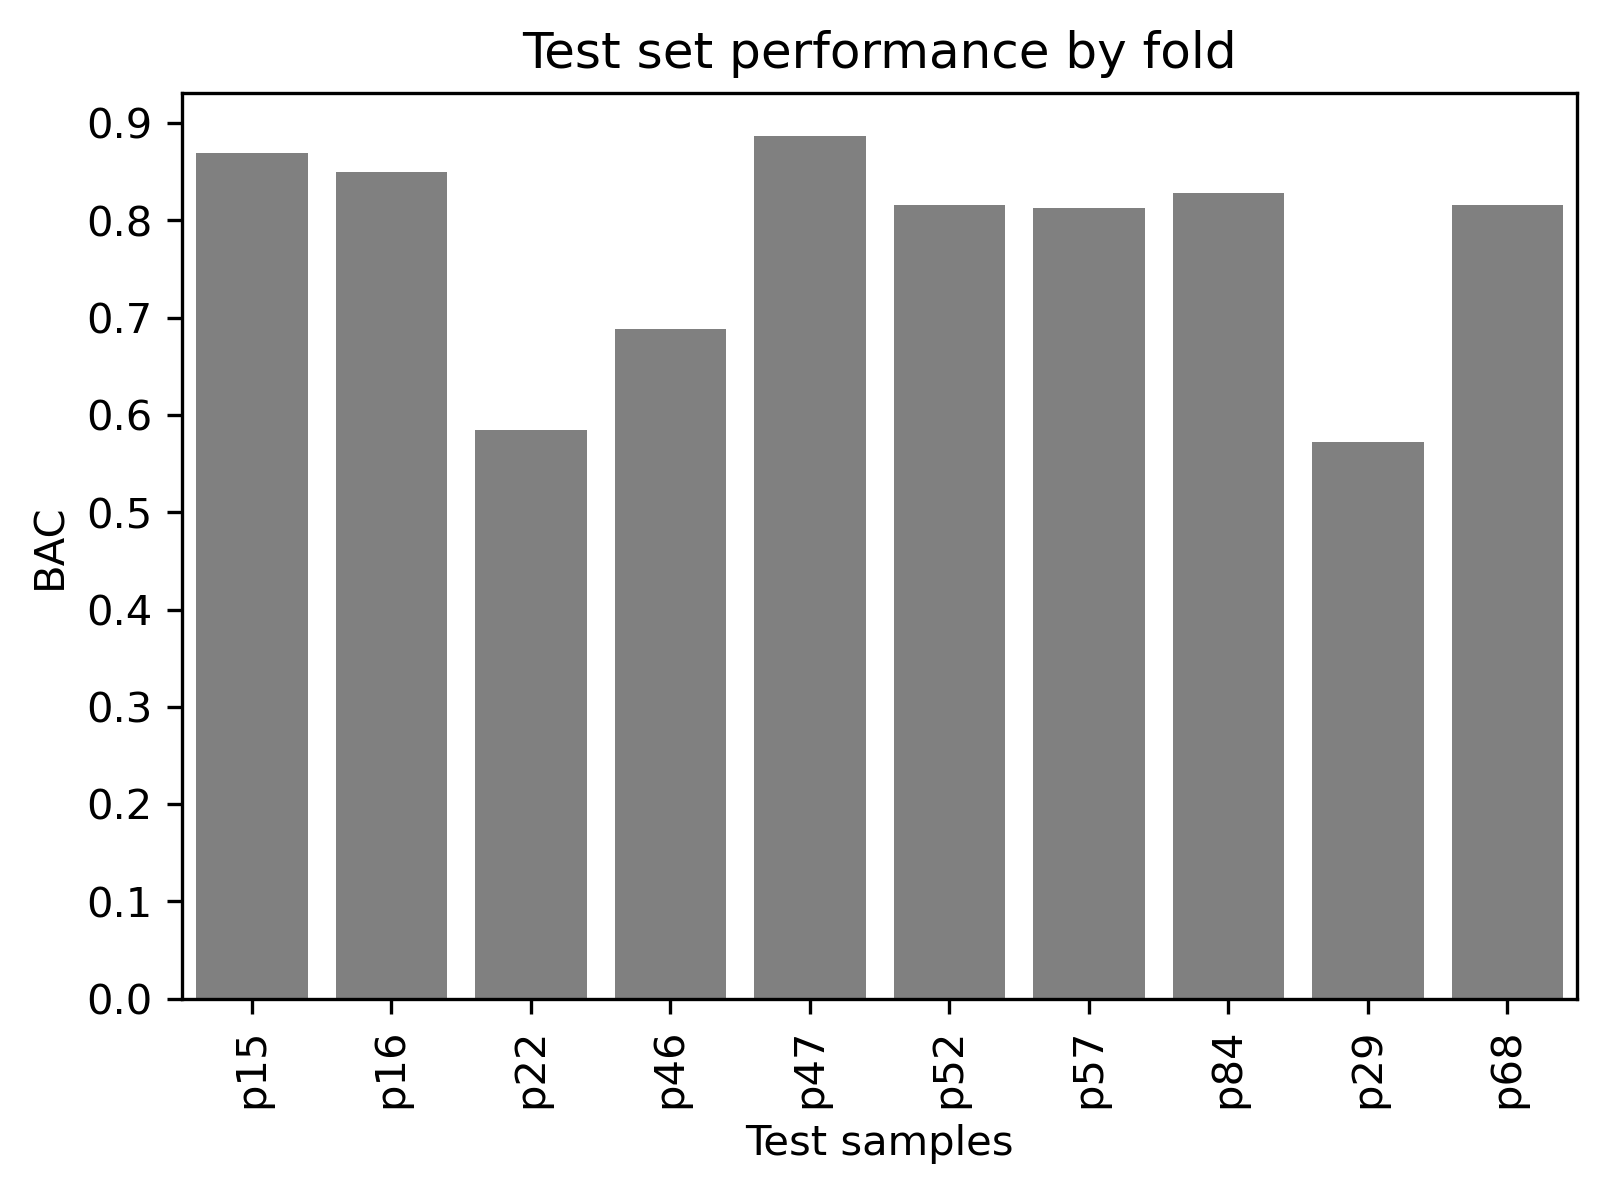

<IPython.core.display.Javascript object>

In [47]:
test_samples = []
for train_idx, test_idx in groupkfold.split(chrometric_data, tp_labels, sample_labels):
    test_samples.append("_".join(np.unique(sample_labels[test_idx])))
cv_bac_df = pd.DataFrame(cv_bacs, columns=["BAC"])
cv_bac_df["Test samples"] = test_samples
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.barplot(x="Test samples", y="BAC", data=cv_bac_df, palette=["gray"], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Test set performance by fold")
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

In [46]:
cv_bacs = cross_val_score(
    lda,
    cv=groupkfold,
    X=chrometric_data,
    y=tp_labels,
    groups=sample_labels,
    scoring="balanced_accuracy",
    n_jobs=10,
)
print("Balanced accuracy: {} (+/- {})".format(np.mean(cv_bacs), np.std(cv_bacs)))

Balanced accuracy: 0.7723809523809524 (+/- 0.1092307154895051)


<IPython.core.display.Javascript object>

In general the confusion matrix again shows a similar picture as seen for the nuclei-based split showing that end of treatment population show phenotypes of the PBMCs significantly different from the other two treatment timepoints.

---

### 3c. Nuclear chromatin biomarkers identifying cancer populations

#### Feature importance

We have validated that there are significant differences between the individual treatment timepoints in particular when comparing PBMCs at the end of the treatment with those of during respectively prior the treatment. We next assess the implicit feature importance of a RandomForest classifier trained on the task to distinguish between the timepoint populations types in order to get an idea of the features are most indicative for the treatment effect.

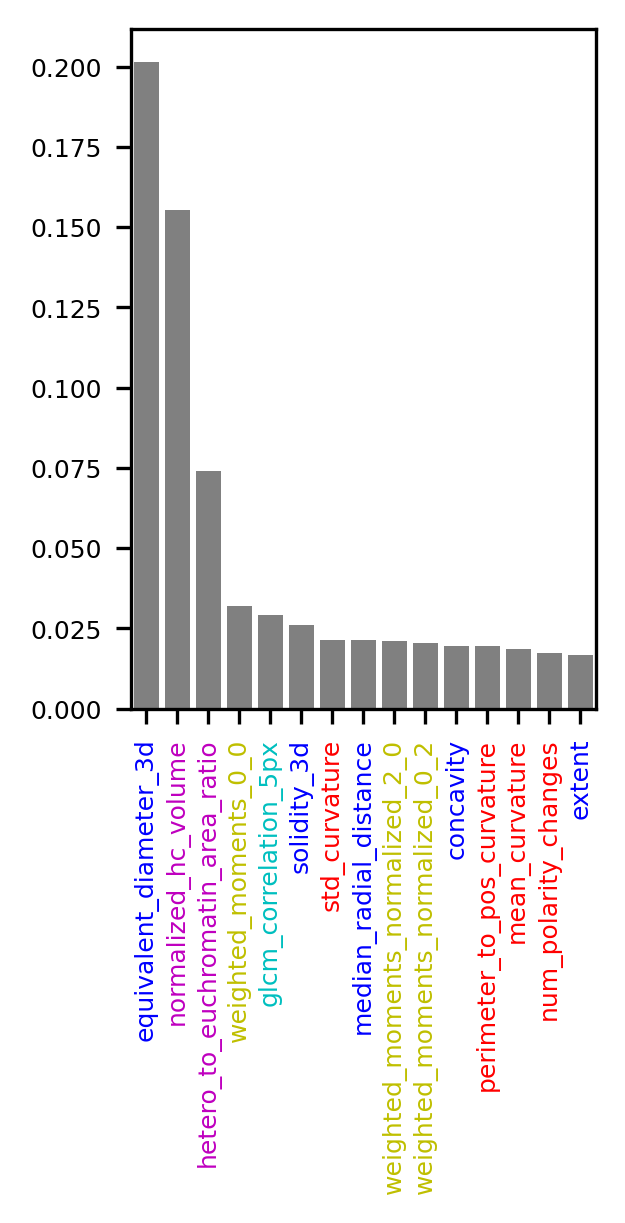

<IPython.core.display.Javascript object>

In [45]:
fig, ax = plot_feature_importance_for_estimator(
    rfc,
    chrometric_data,
    tp_labels,
    scale_features=False,
    feature_color_dict=feature_color_dict,
    n_features=15,
    cmap=["gray"],
    figsize=[2, 3],
)

The analysis suggests that the features that changes the most between the individual treatment populations is the size of the nucleus as well as the heterochromatin content as well as the shape of the overall DNA intensity distribution inside the nucleus in 2D.

The previously shown feature importance plots already suggest a number of candidate chrometric biomarkers that capture the differences of the nuclear phenotypes of the PBMCs during the treatment. We now run marker screen by testing for differential distributions of the individual chrometric features between the different treatment timepoint populations. To this end, we apply a t-test to test for difference in the means and adjust for multiple testing using the Benjamini-Hochberg procedure.

In [34]:
marker_screen_results = find_markers(chrometric_data, tp_labels)

Run marker screen:   0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

#### Prior treatment

At first we look at the features whose mean is significantly different prior the proton therapry treatment compared to during respectively the end of it.

In [35]:
marker_screen_results.loc[marker_screen_results.label == "prior"].head(10)

label                            marker        fc  abs_delta_fc  \
23  prior              weighted_moments_0_0  1.127197      0.127197   
8   prior                     std_curvature  0.886236      0.113764   
3   prior               min_radial_distance  1.076610      0.076610   
57  prior              normalized_hc_volume  0.950944      0.049056   
21  prior              glcm_correlation_5px  1.033129      0.033129   
5   prior                         concavity  0.804539      0.195461   
55  prior                            extent  1.043680      0.043680   
0   prior              min_caliper_distance  1.034280      0.034280   
17  prior  hetero_to_euchromatin_area_ratio  0.932600      0.067400   
56  prior                       solidity_3d  1.018098      0.018098   

             pval    pval_adjust  
23  9.691845e-140  8.168841e-139  
8    3.194077e-98   2.174429e-97  
3    2.867850e-90   1.750377e-89  
57   4.268410e-80   2.360964e-79  
21   4.906604e-76   2.554320e-75  
5    3.811556e-69   1.823366e-68  
55   3.837066e-63   1.697902e-62  
0    1.867008e-58   8.060012e-58  
17   1.060499e-56   4.365309e-56  
56   4.375241e-55   1.720928e-54

<IPython.core.display.Javascript object>

We find that the PBMCs prior the treatment are average slightly larger, the projected DNA image and a more variable curvature of the nuclear boundary of the projected nuclear mask.

---

#### During treatment

Next we look at the features whose mean is significantly different in the during treatment population.

In [36]:
marker_screen_results.loc[marker_screen_results.label == "during"].head(10)

label                            marker        fc  abs_delta_fc  \
54  during            equivalent_diameter_3d  1.086945      0.086945   
23  during              weighted_moments_0_0  0.811670      0.188330   
57  during              normalized_hc_volume  1.197685      0.197685   
17  during  hetero_to_euchromatin_area_ratio  1.307008      0.307008   
21  during              glcm_correlation_5px  0.932384      0.067616   
8   during                     std_curvature  1.235213      0.235213   
24  during   weighted_moments_normalized_0_2  1.244351      0.244351   
29  during   weighted_moments_normalized_2_0  1.258266      0.258266   
15  during        perimeter_to_pos_curvature  0.958121      0.041879   
14  during       num_prominant_neg_curvature  1.284221      0.284221   

             pval    pval_adjust  
54   0.000000e+00   0.000000e+00  
23   0.000000e+00   0.000000e+00  
57   0.000000e+00   0.000000e+00  
17   0.000000e+00   0.000000e+00  
21  1.687101e-279  3.732712e-278  
8   9.340110e-271  1.836888e-269  
24  5.090366e-226  9.009948e-225  
29  1.619886e-215  2.606545e-214  
15  2.833664e-209  4.179654e-208  
14  5.803678e-194  7.901931e-193

<IPython.core.display.Javascript object>

The during treamtent population seems to feature PBMCs that are slightly larger and have a significantly larger heterochromatin content. Additionally, the skewness and kurtosis of the DNA distribution of the projected DNA image is reduced.

---

#### End of treatment

Finally, we also evaluate the chrometric phenotype of PBMCs at the end of the proton therapy treatment.

In [37]:
marker_screen_results.loc[marker_screen_results.label == "end"].head(10)

label                            marker        fc  abs_delta_fc  \
57   end              normalized_hc_volume  0.870271      0.129729   
54   end            equivalent_diameter_3d  0.922883      0.077117   
17   end  hetero_to_euchromatin_area_ratio  0.804125      0.195875   
15   end        perimeter_to_pos_curvature  1.037851      0.037851   
24   end   weighted_moments_normalized_0_2  0.863645      0.136355   
29   end   weighted_moments_normalized_2_0  0.861252      0.138748   
7    end                    mean_curvature  1.039989      0.039989   
18   end                 glcm_contrast_5px  1.126001      0.126001   
21   end              glcm_correlation_5px  1.036854      0.036854   
13   end       num_prominant_pos_curvature  0.870236      0.129764   

             pval    pval_adjust  
57   0.000000e+00   0.000000e+00  
54   0.000000e+00   0.000000e+00  
17   0.000000e+00   0.000000e+00  
15  4.560827e-176  5.045415e-175  
24  1.314119e-130  1.057268e-129  
29  1.007892e-117  7.433204e-117  
7   2.793459e-101  1.977769e-100  
18   3.677410e-94   2.410747e-93  
21   9.565247e-93   6.046603e-92  
13   9.629903e-84   5.498364e-83

<IPython.core.display.Javascript object>

The PBMCs at the end of the treatment have on average smaller nuclei with less heterochromatin content and whose DNA distribution shows a significantly increased skewness and kurtosis.

---

As a joint proxy to study the alterations in size, we focus at the nuclear volume, the variation in the shape by the concavity of the nucleus and the change in chromatin compaction by the relative heterochromatin to euchromatin ratio, additionally we observe differences in the curvature. Finally, the shape of the DNA intensity distributions of the z-projected nucleus are significantly different. To visualize those differences, we look at the distributions of those markers in the different cancer types.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-5.018e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=1.011e+02
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=5.008e+01


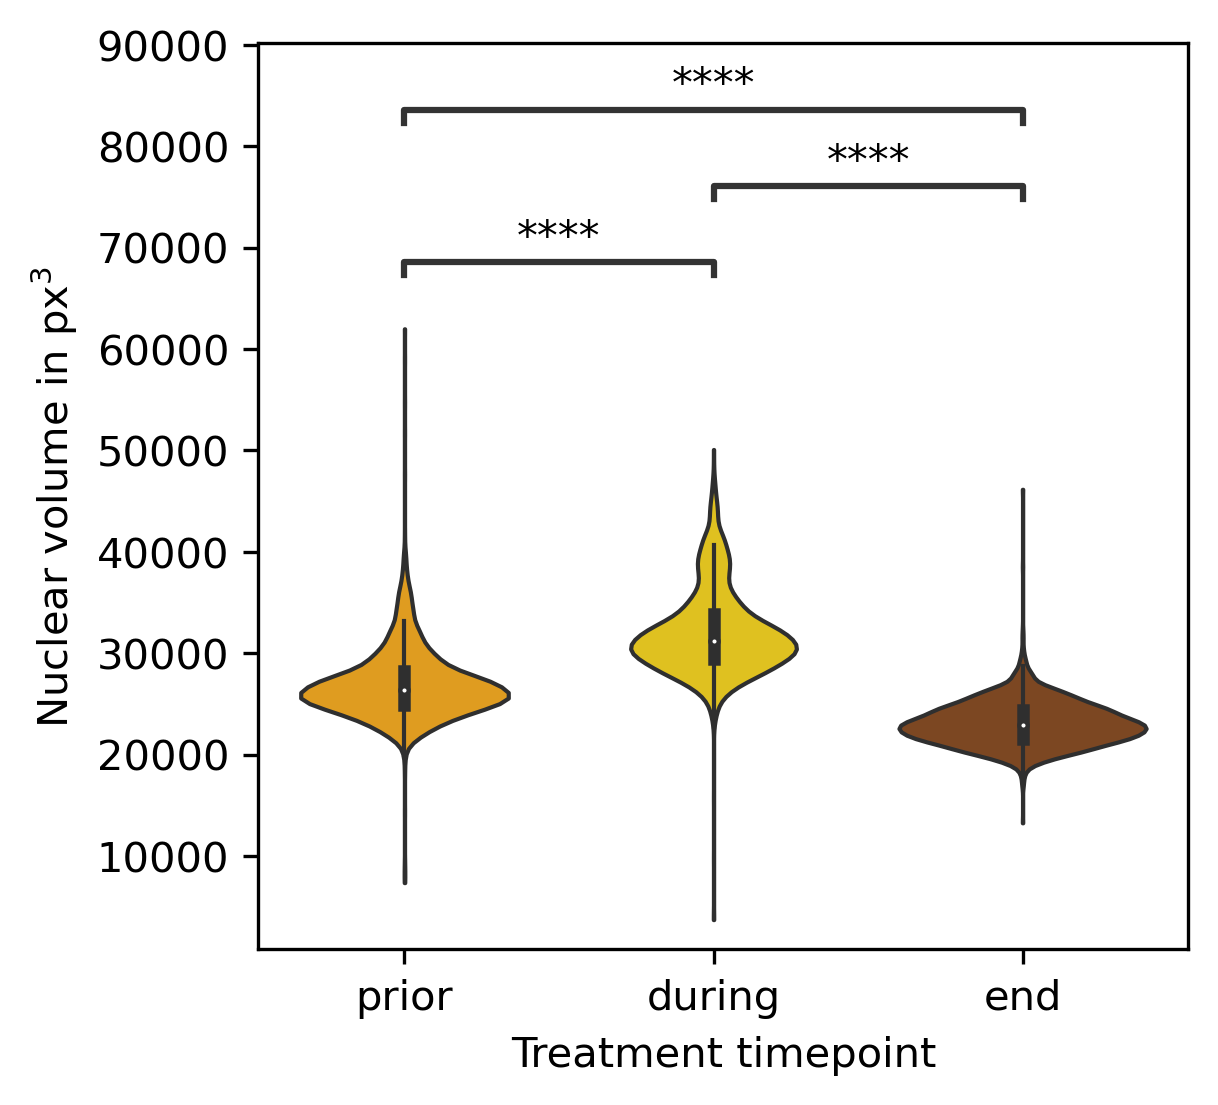

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-7.759e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=1.036e+02
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.158e-92 t=2.081e+01


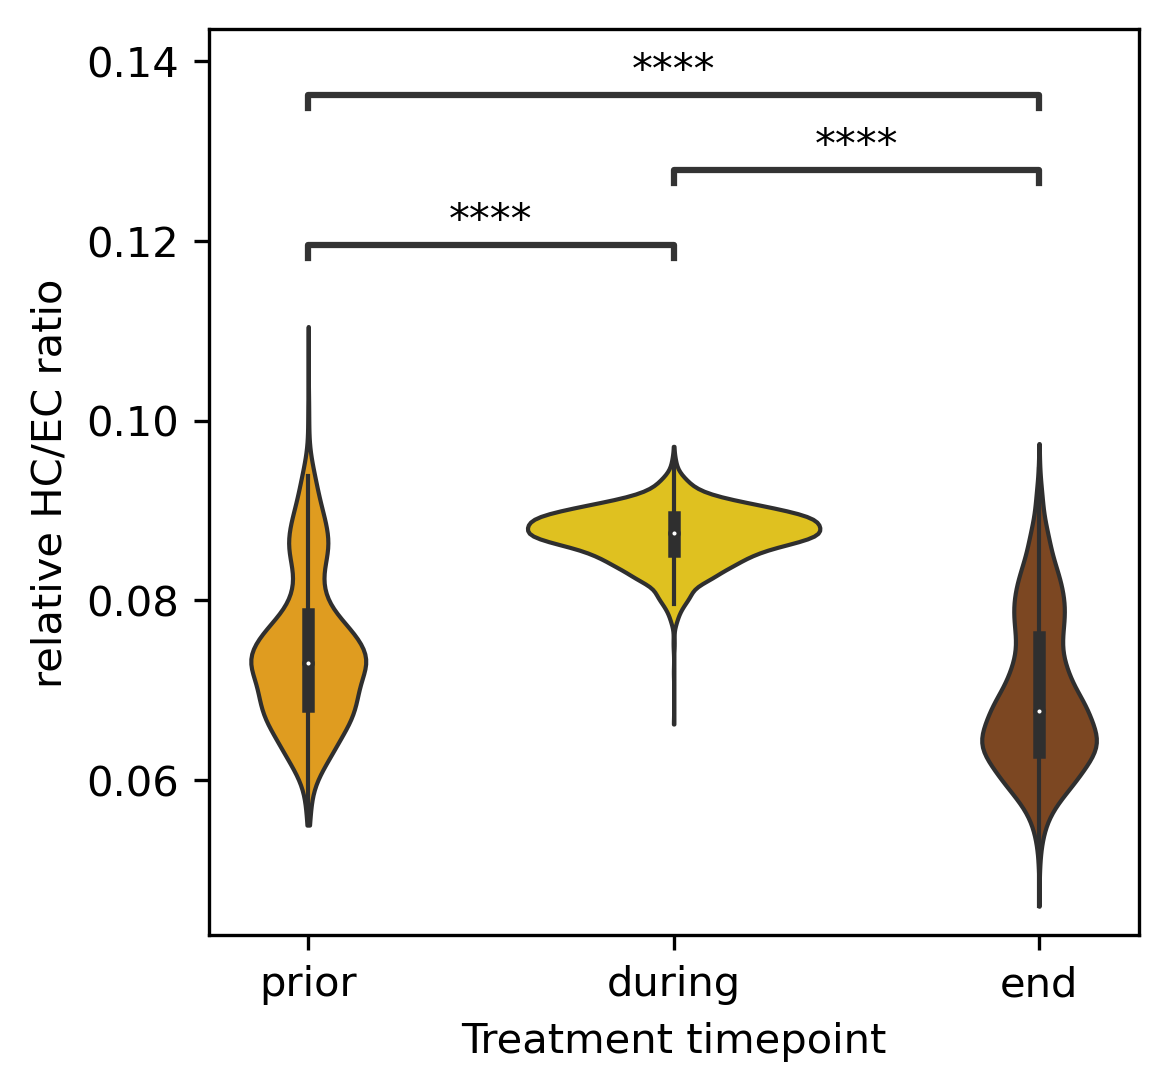

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.053e-233 t=-3.426e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:6.518e-213 t=3.254e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:3.959e-02 t=-2.059e+00


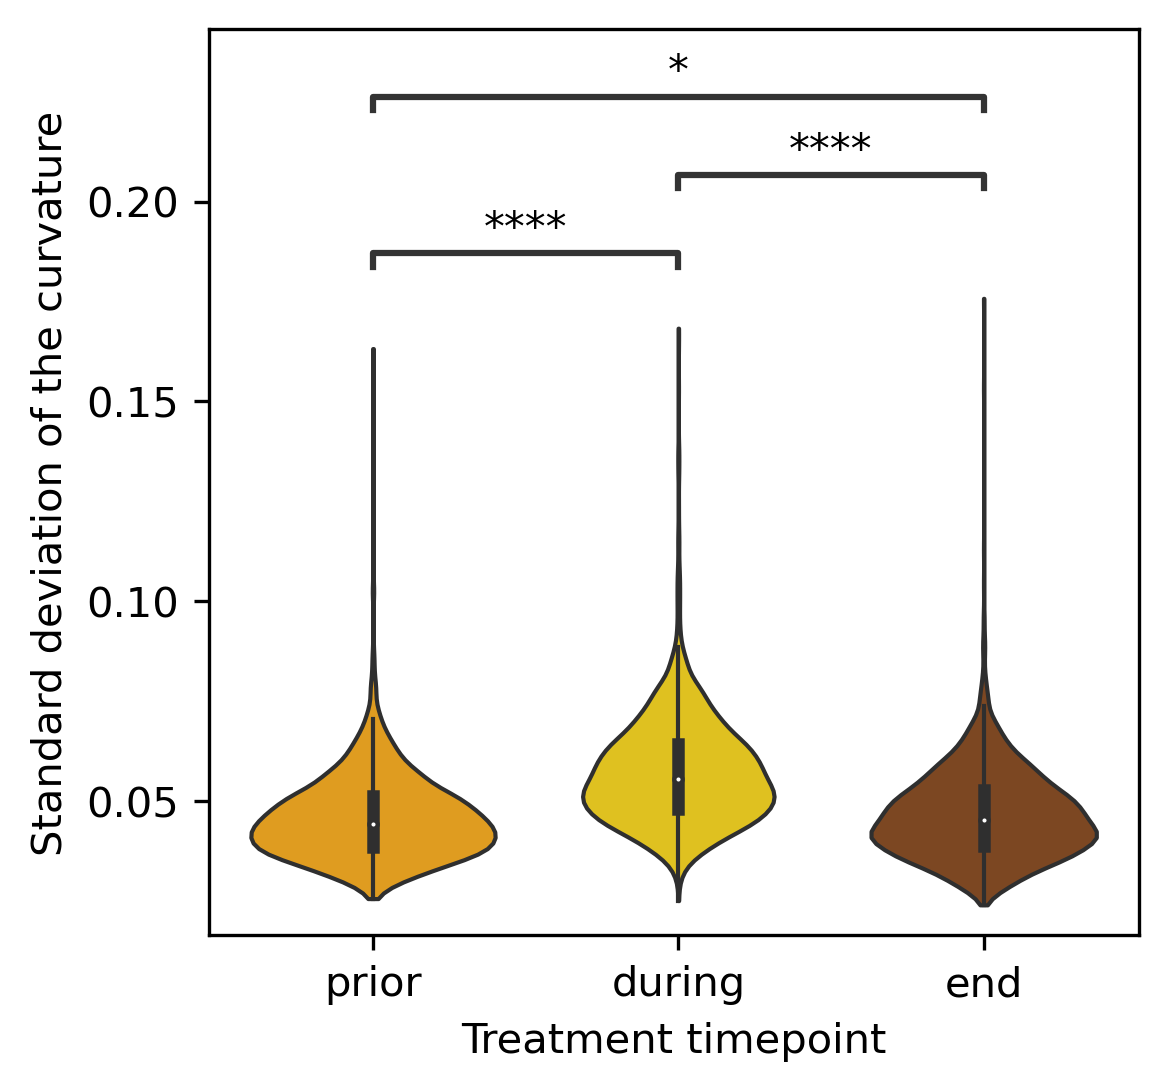

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.358e-221 t=3.323e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.837e-234 t=-3.432e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.024e-01 t=-1.275e+00


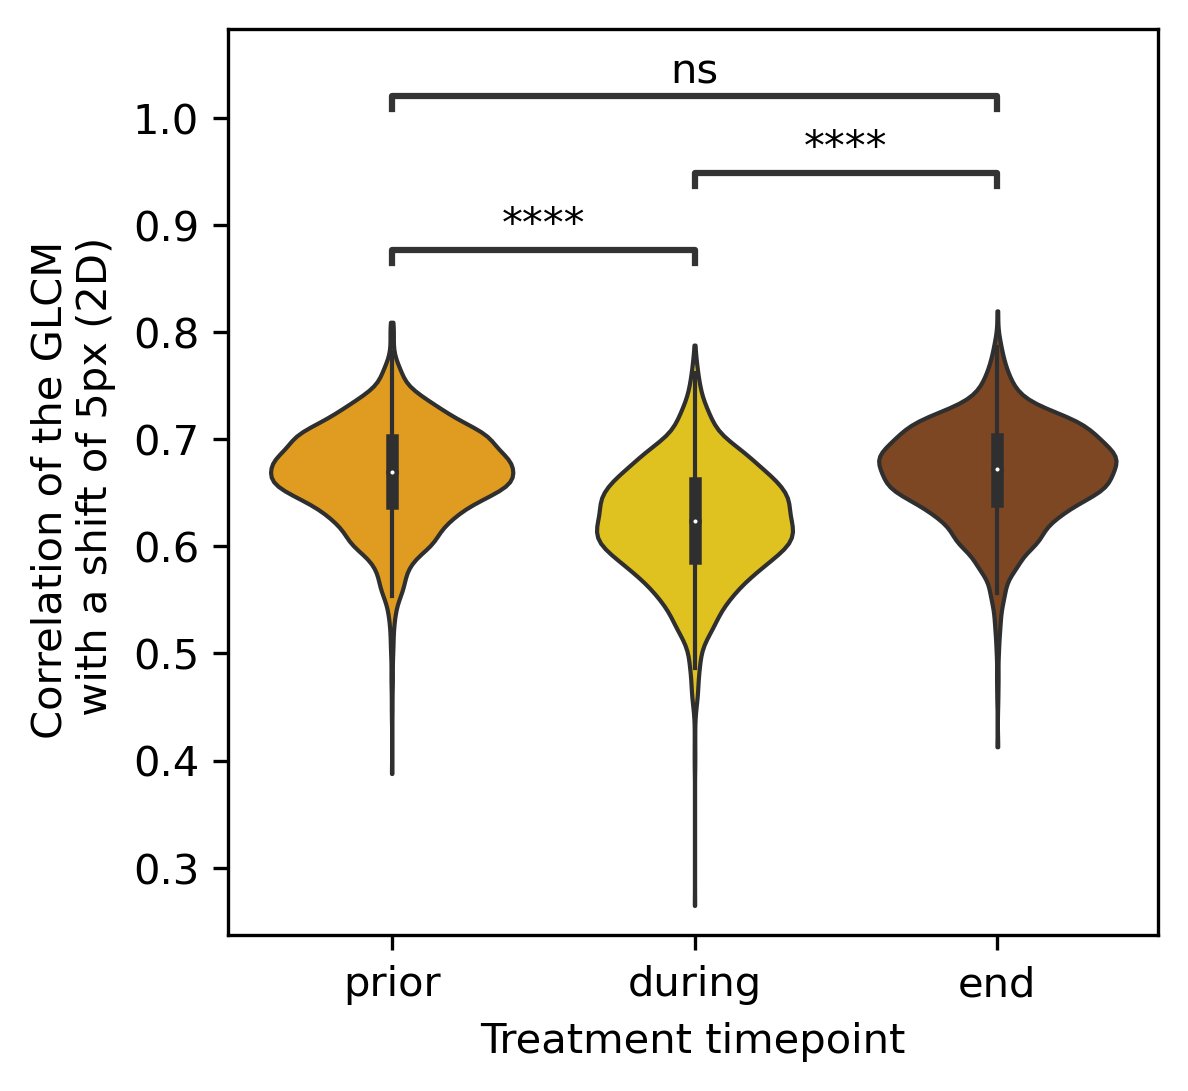

<IPython.core.display.Javascript object>

In [38]:
markers = [
    "volume",
    "hetero_to_euchromatin_volume_ratio",
    "std_curvature",
    "glcm_correlation_5px",
]
marker_labels = [
    r"Nuclear volume in px$^3$",
    "relative HC/EC ratio",
    "Standard deviation of the curvature",
    "Correlation of the GLCM \n with a shift of 5px (2D)",
]
plot_timepoint_markers_dist(
    data, markers, marker_labels, cut=0, palette=color_palette, figsize=[4, 4]
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-5.018e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=1.011e+02
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=5.008e+01


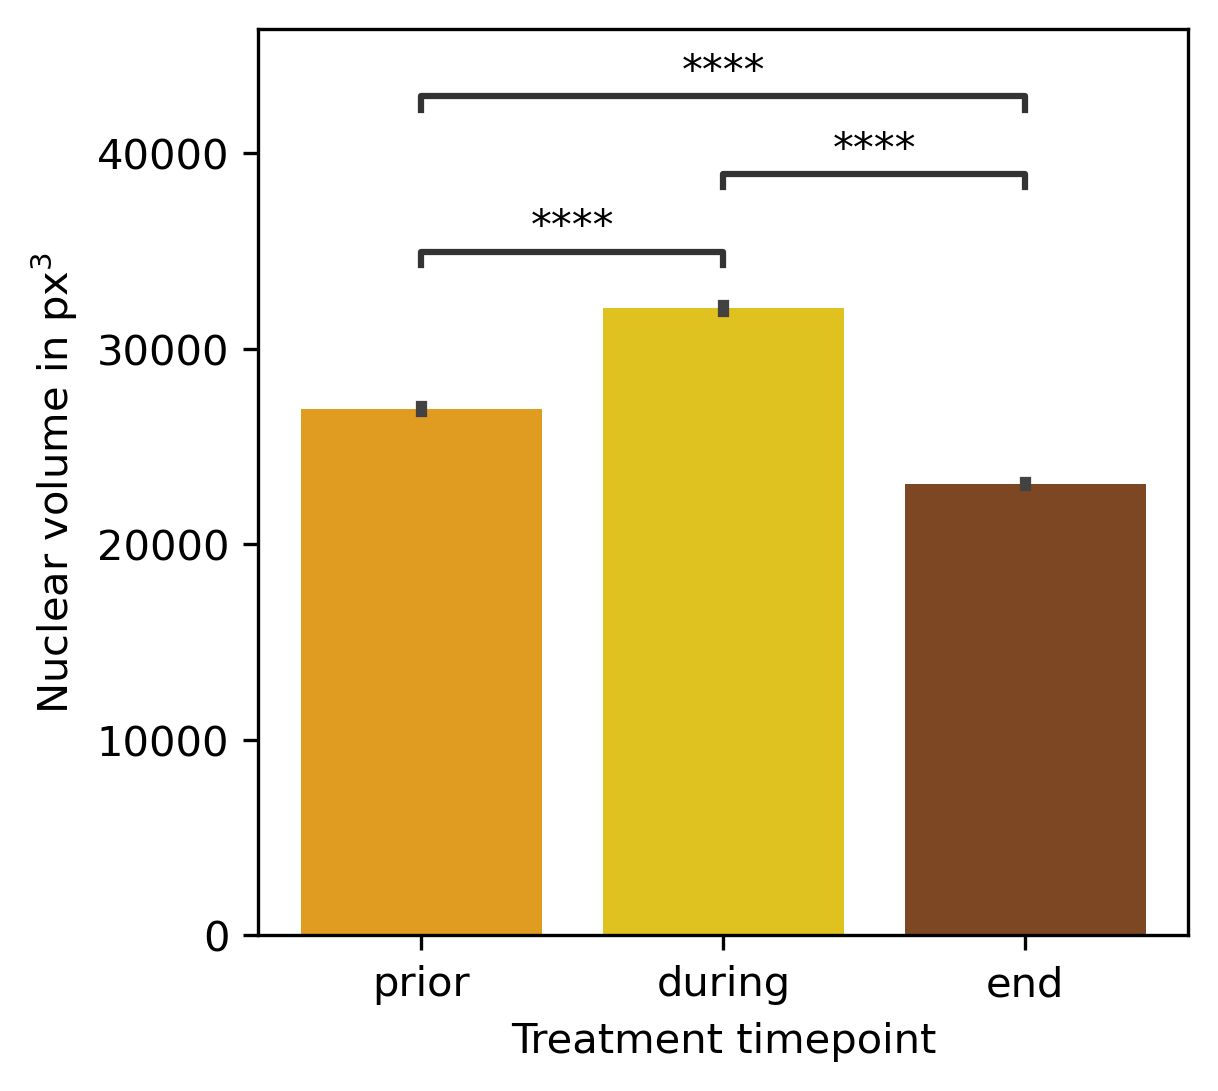

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-7.759e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=1.036e+02
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.158e-92 t=2.081e+01


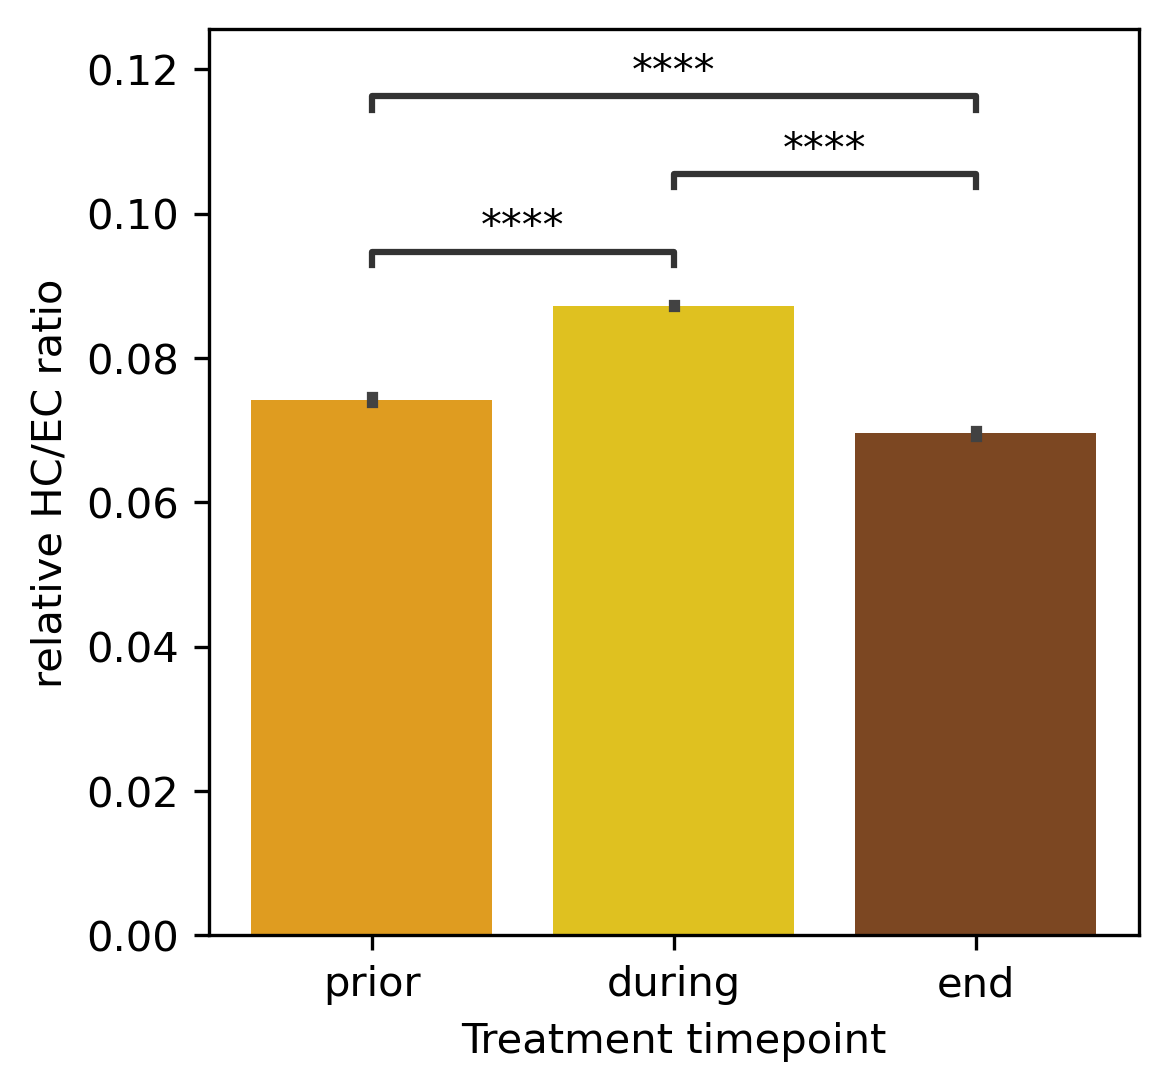

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.053e-233 t=-3.426e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:6.518e-213 t=3.254e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:3.959e-02 t=-2.059e+00


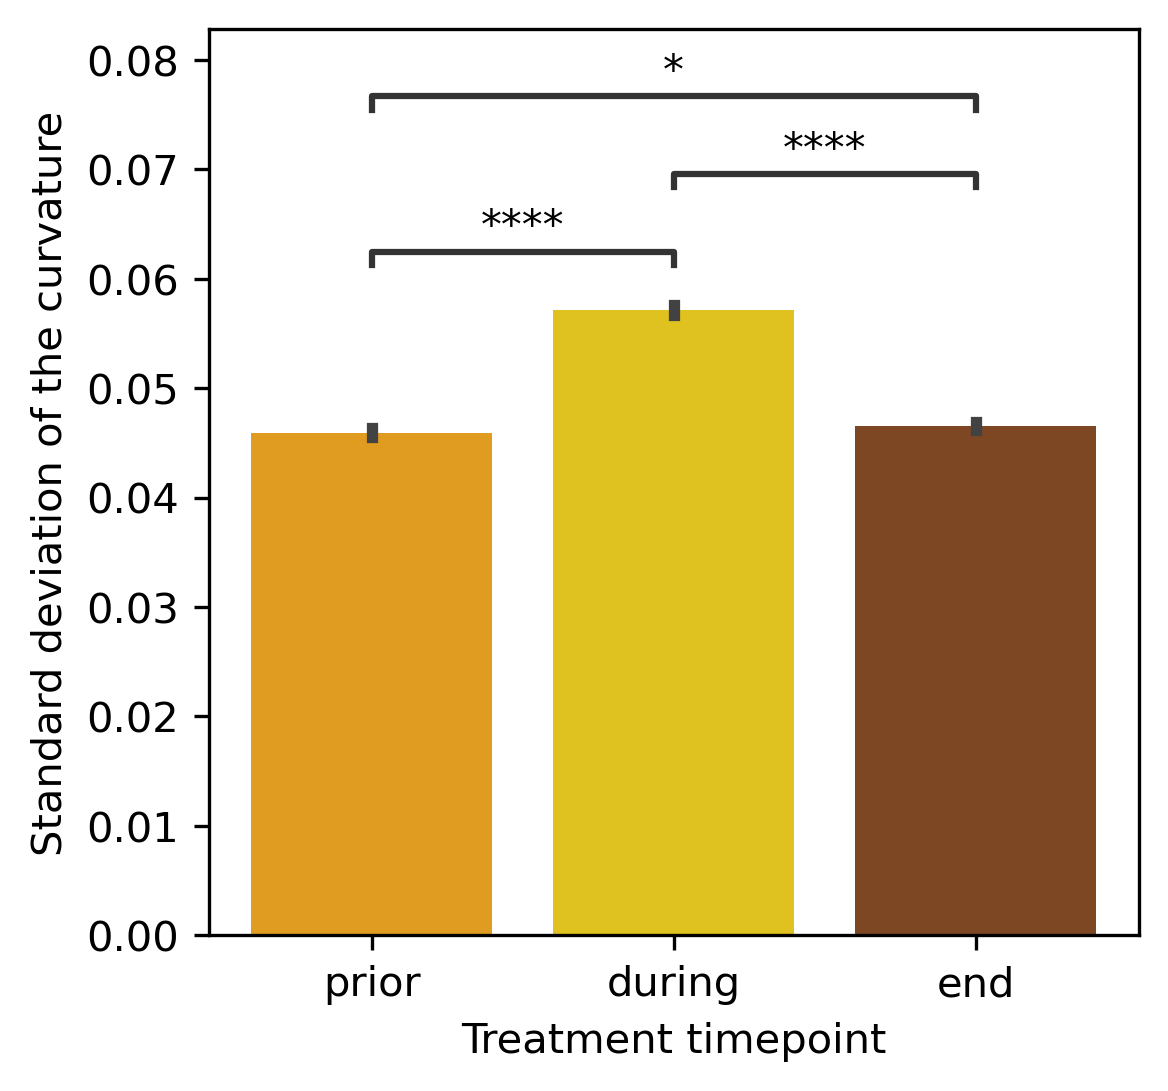

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.358e-221 t=3.323e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.837e-234 t=-3.432e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.024e-01 t=-1.275e+00


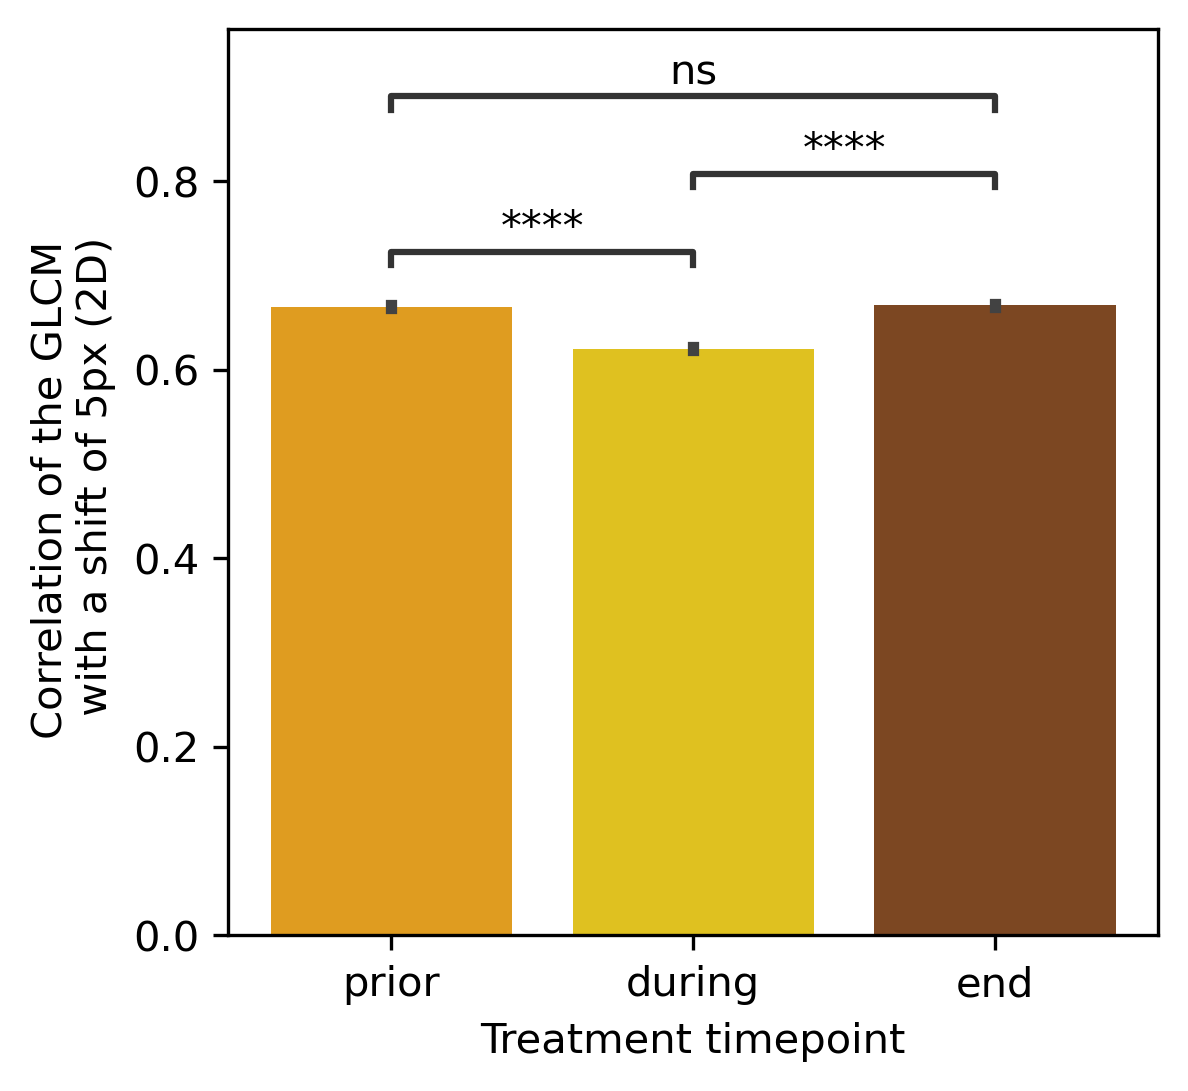

<IPython.core.display.Javascript object>

In [39]:
plot_timepoint_markers_dist(
    data, markers, marker_labels, cut=0, plot_type="bar", palette=color_palette
)

---

### 3d. Proteomic differences of PBMCs in cancer

Finally, we also assess the proteomic differences between the different treatment timepoint populations. To this end, we plot the relative Lamin and gH2AX expression measured by the sum of the intensities of the corresponding imaging channels normalized by the nuclear volume. Additionally, we plot the number of identified gH2AX foci which are computed as the local maxima peaks found in the corresponding channel images.

Note that those features are only available for the first data set that was stained for those proteins.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:6.132e-02 t=-1.872e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.914e-63 t=-1.703e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.215e-119 t=-2.383e+01


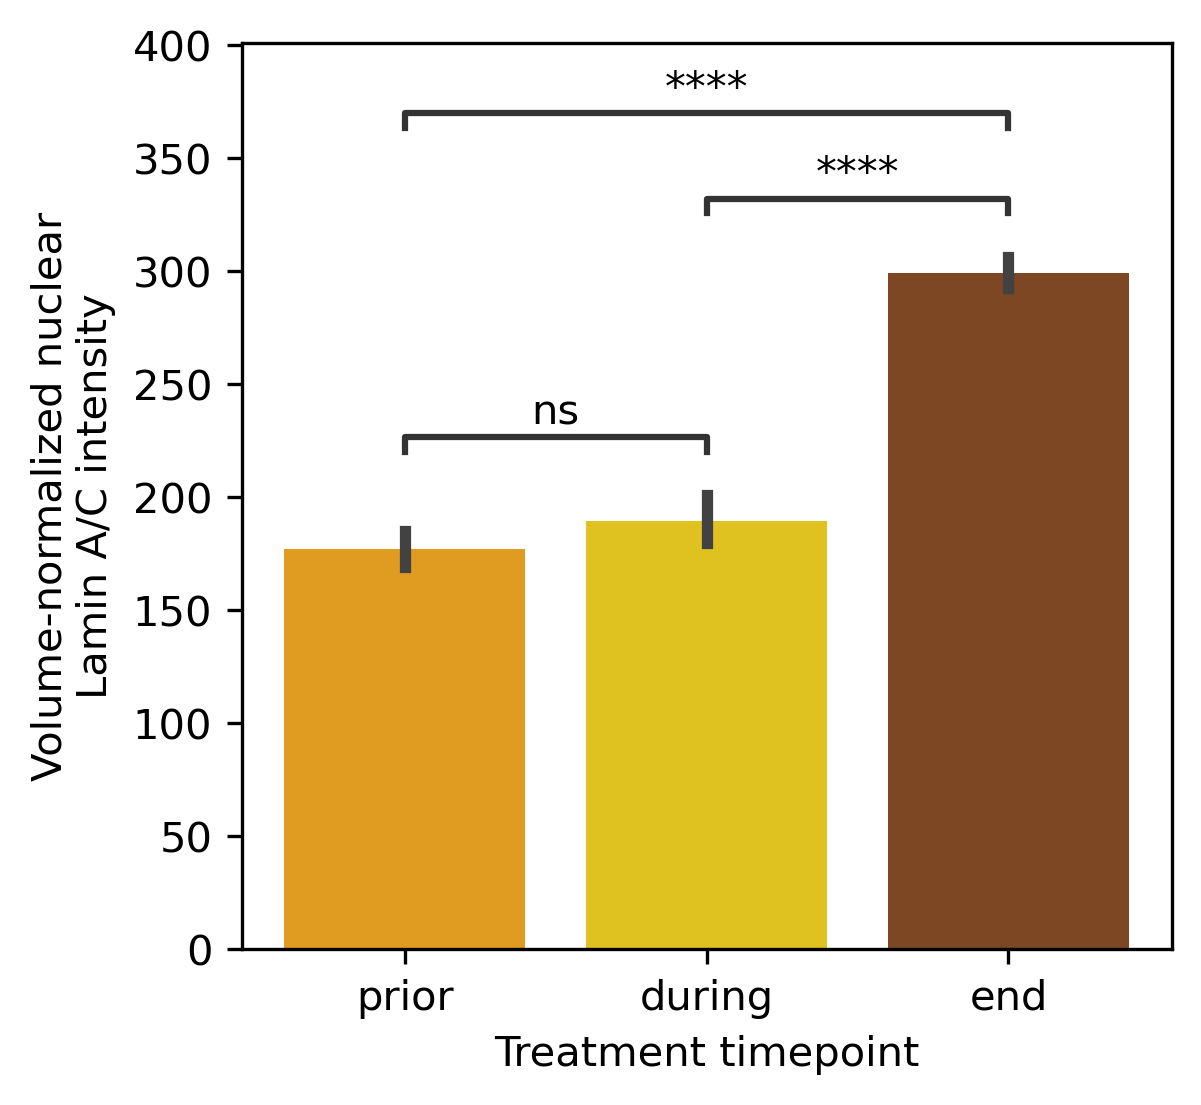

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.201e-212 t=3.252e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-1.605e+02
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-1.270e+02


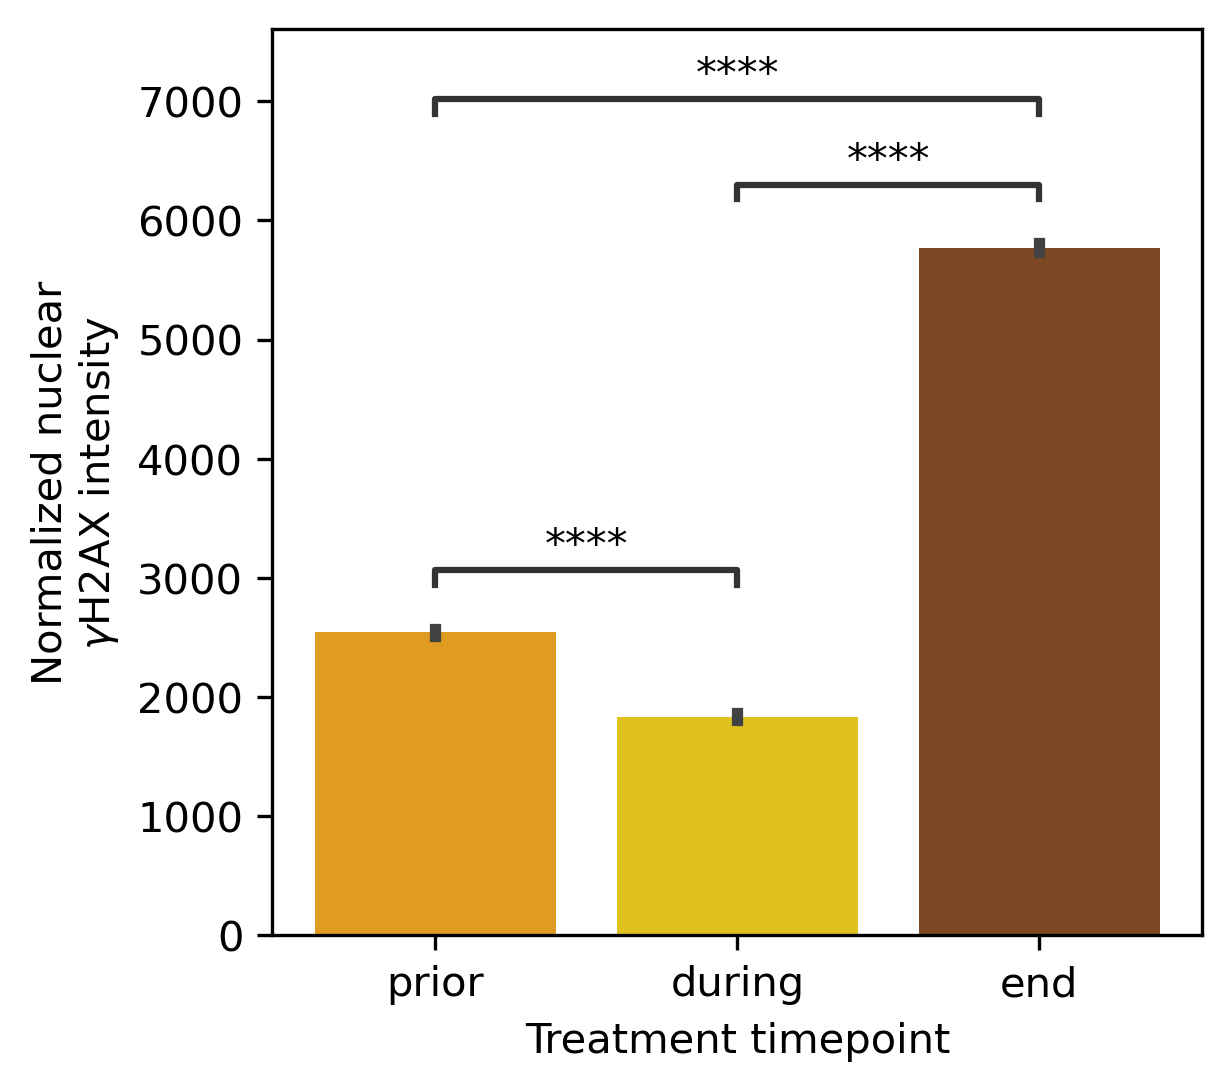

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:2.135e-15 t=-7.956e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.232e-150 t=2.696e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.827e-78 t=1.905e+01


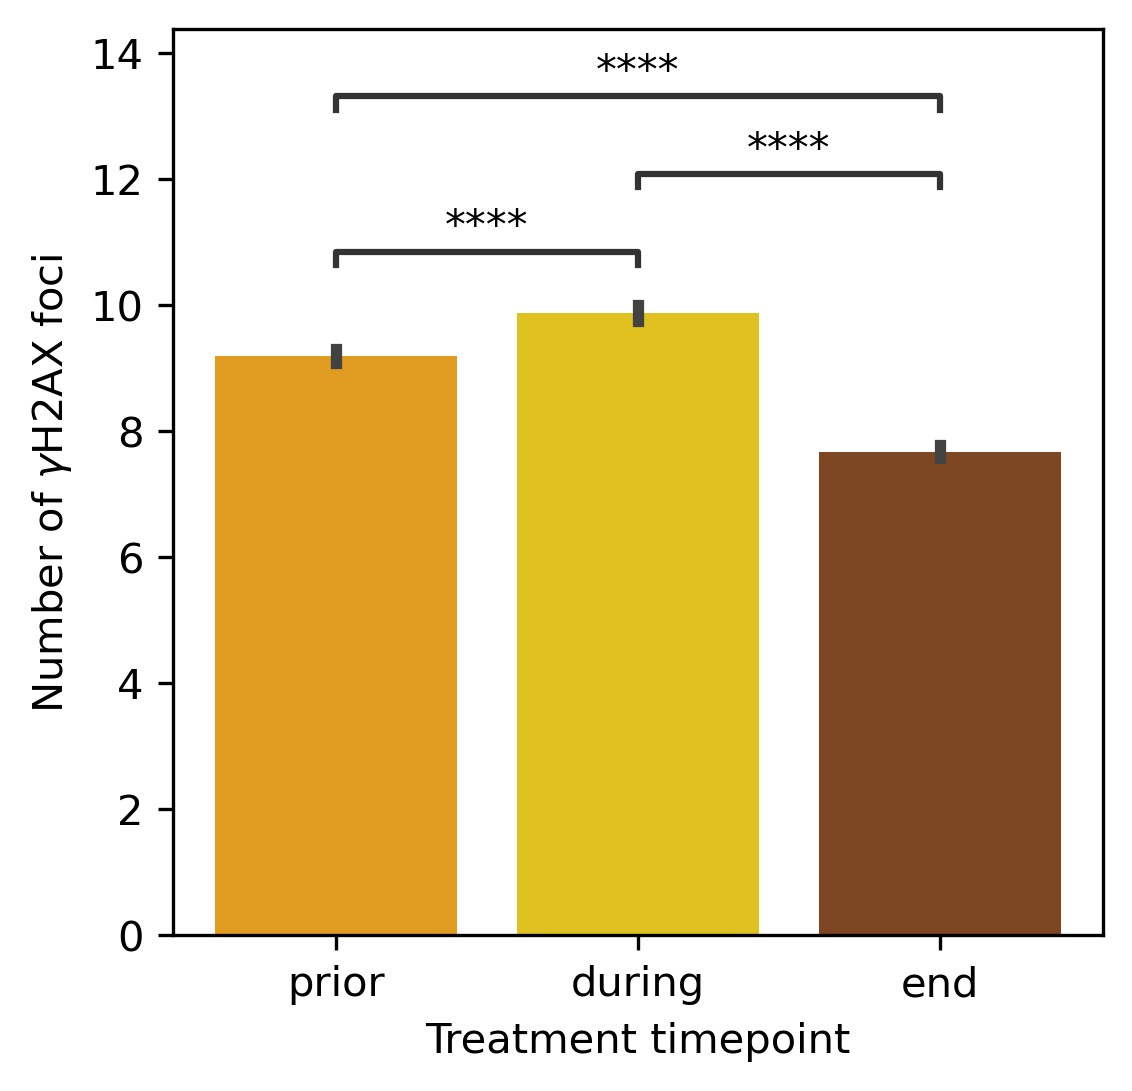

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.478e-28 t=-1.115e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.013e-276 t=3.763e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.974e-137 t=2.562e+01


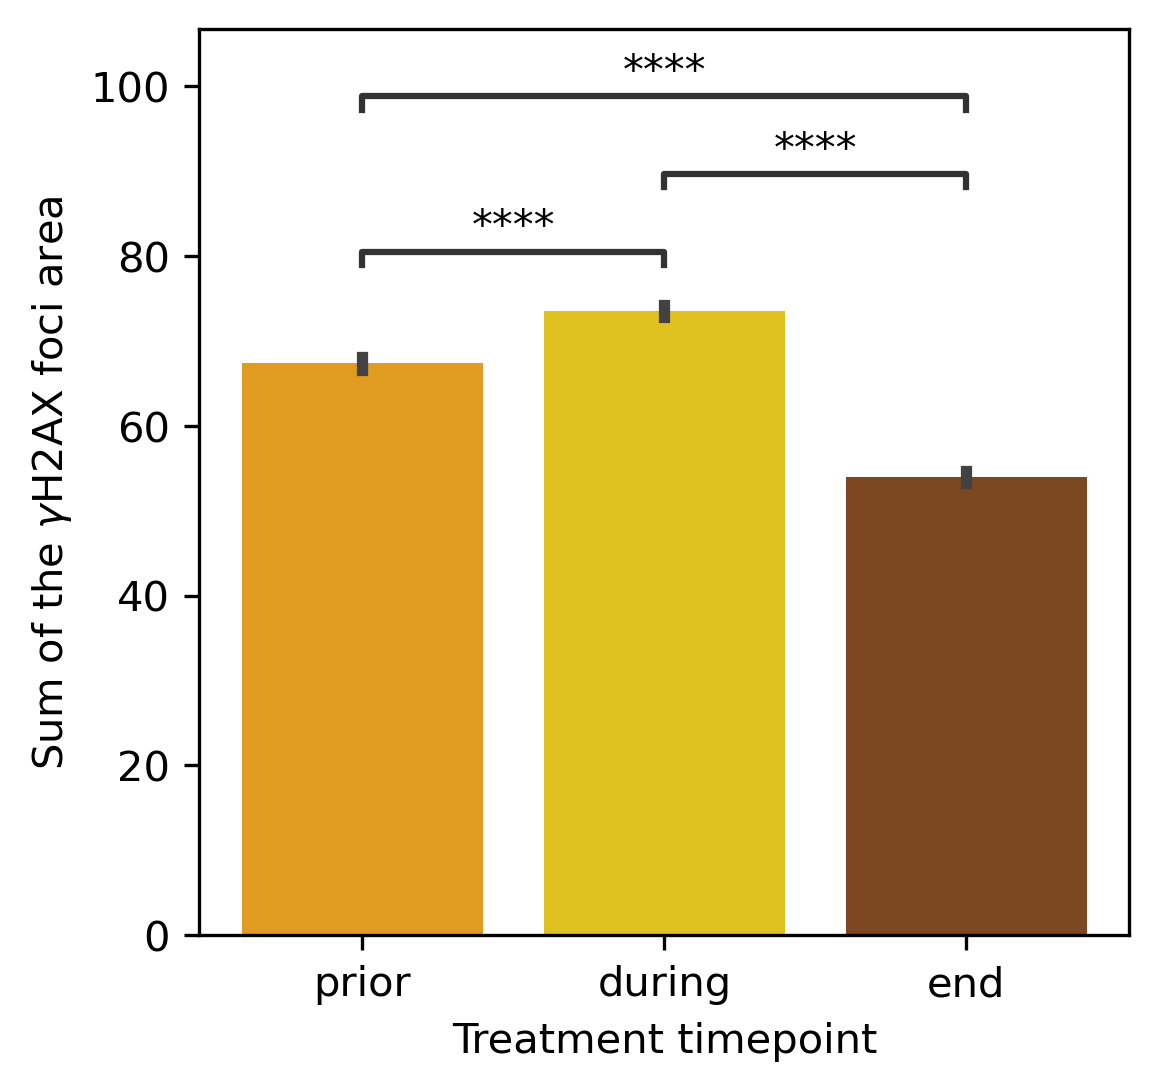

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:2.271e-01 t=-1.208e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.269e-11 t=6.608e+00
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:7.302e-09 t=5.793e+00


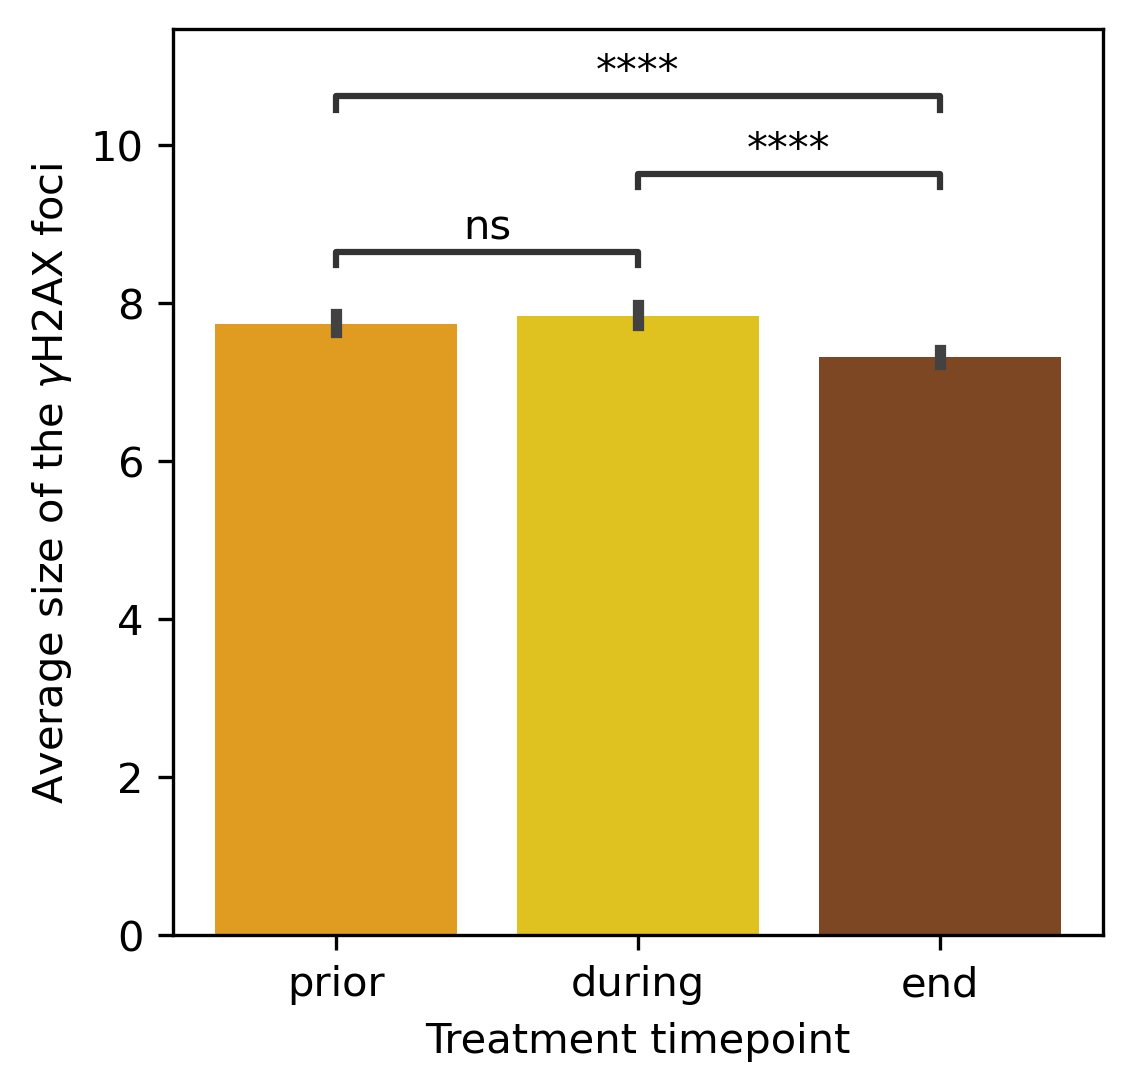

<IPython.core.display.Javascript object>

In [40]:
markers = [
    "rel_lamin_3d_int",
    "rel_gh2ax_3d_int",
    "gh2ax_foci_count",
    "gh2ax_sum_foci_area",
    "gh2ax_avg_foci_area",
]
marker_labels = [
    "Volume-normalized nuclear\nLamin A/C intensity",
    "Normalized nuclear\n" r"$\gamma$H2AX intensity",
    r"Number of $\gamma$H2AX foci",
    r"Sum of the $\gamma$H2AX foci area",
    r"Average size of the $\gamma$H2AX foci",
]
plot_timepoint_markers_dist(
    data,
    markers,
    marker_labels,
    quantiles=None,
    cut=0,
    plot_type="bar",
    palette=color_palette,
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:6.132e-02 t=-1.872e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.914e-63 t=-1.703e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.215e-119 t=-2.383e+01


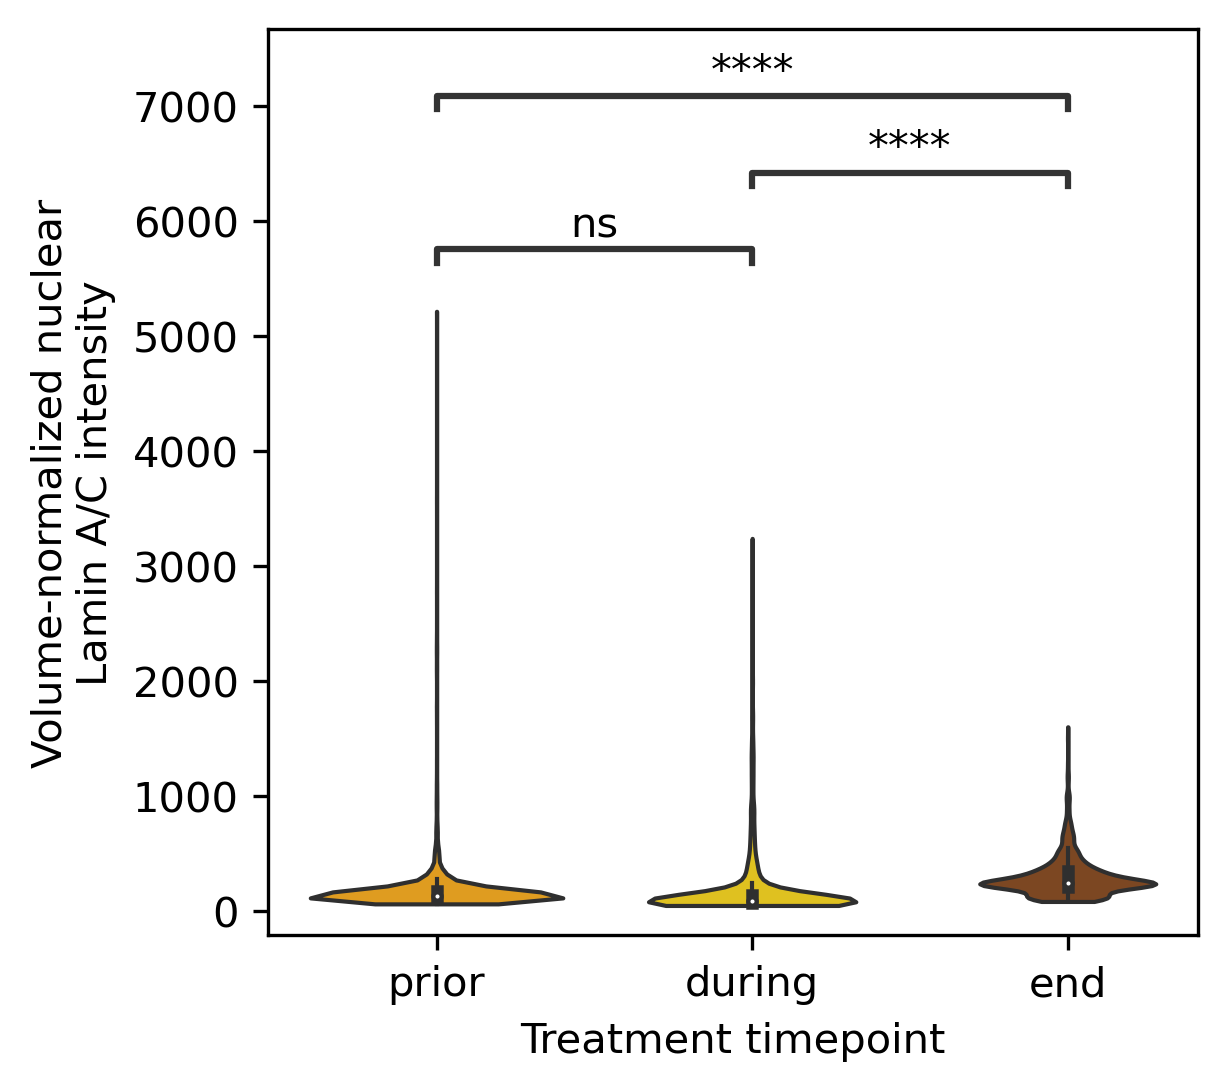

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.201e-212 t=3.252e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-1.605e+02
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-1.270e+02


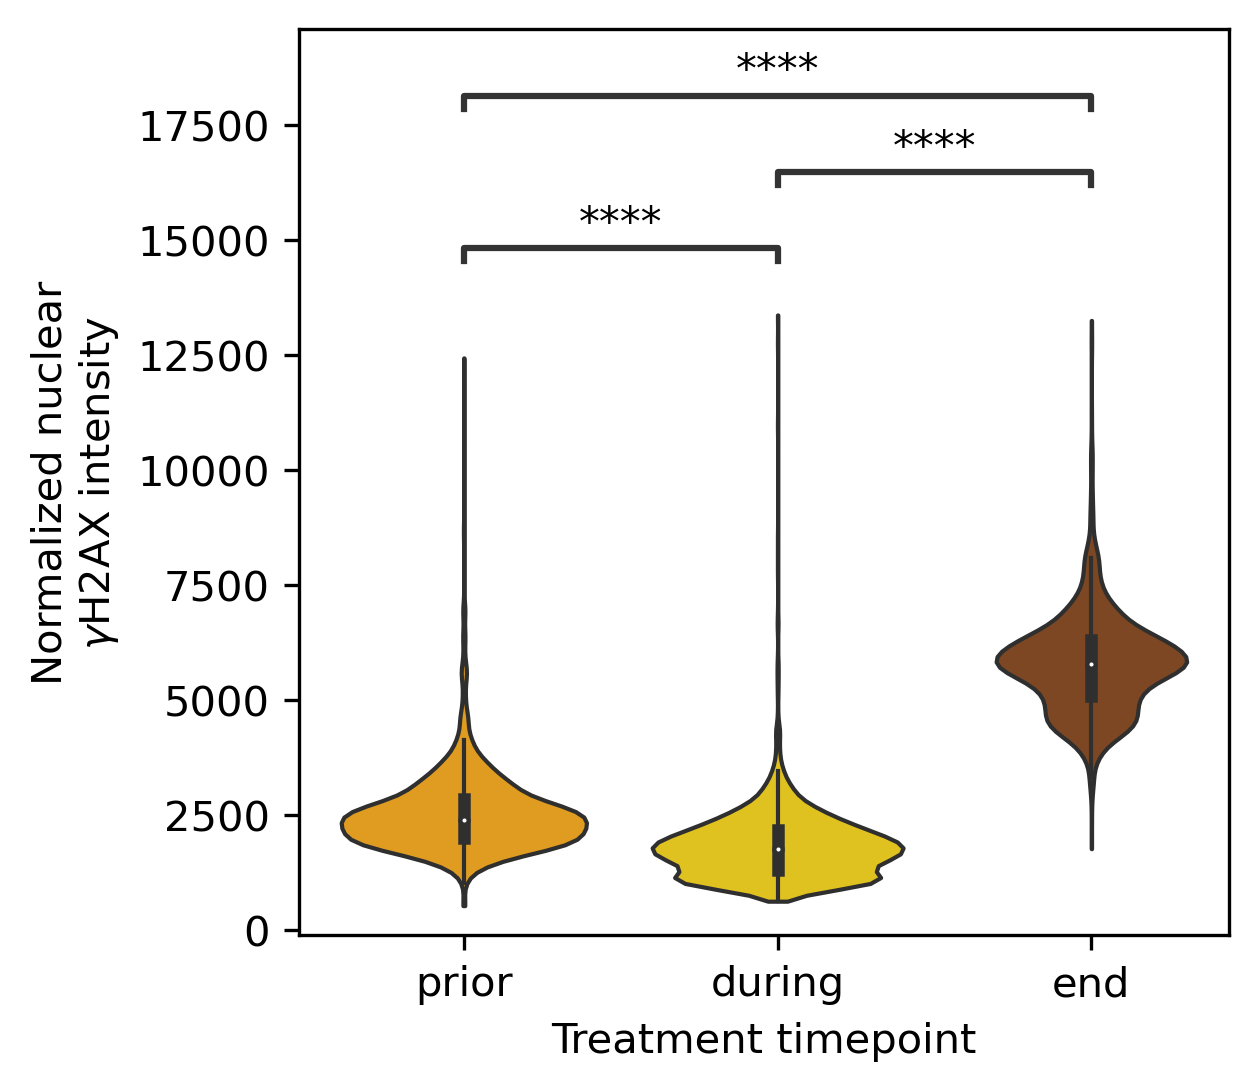

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:2.135e-15 t=-7.956e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.232e-150 t=2.696e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.827e-78 t=1.905e+01


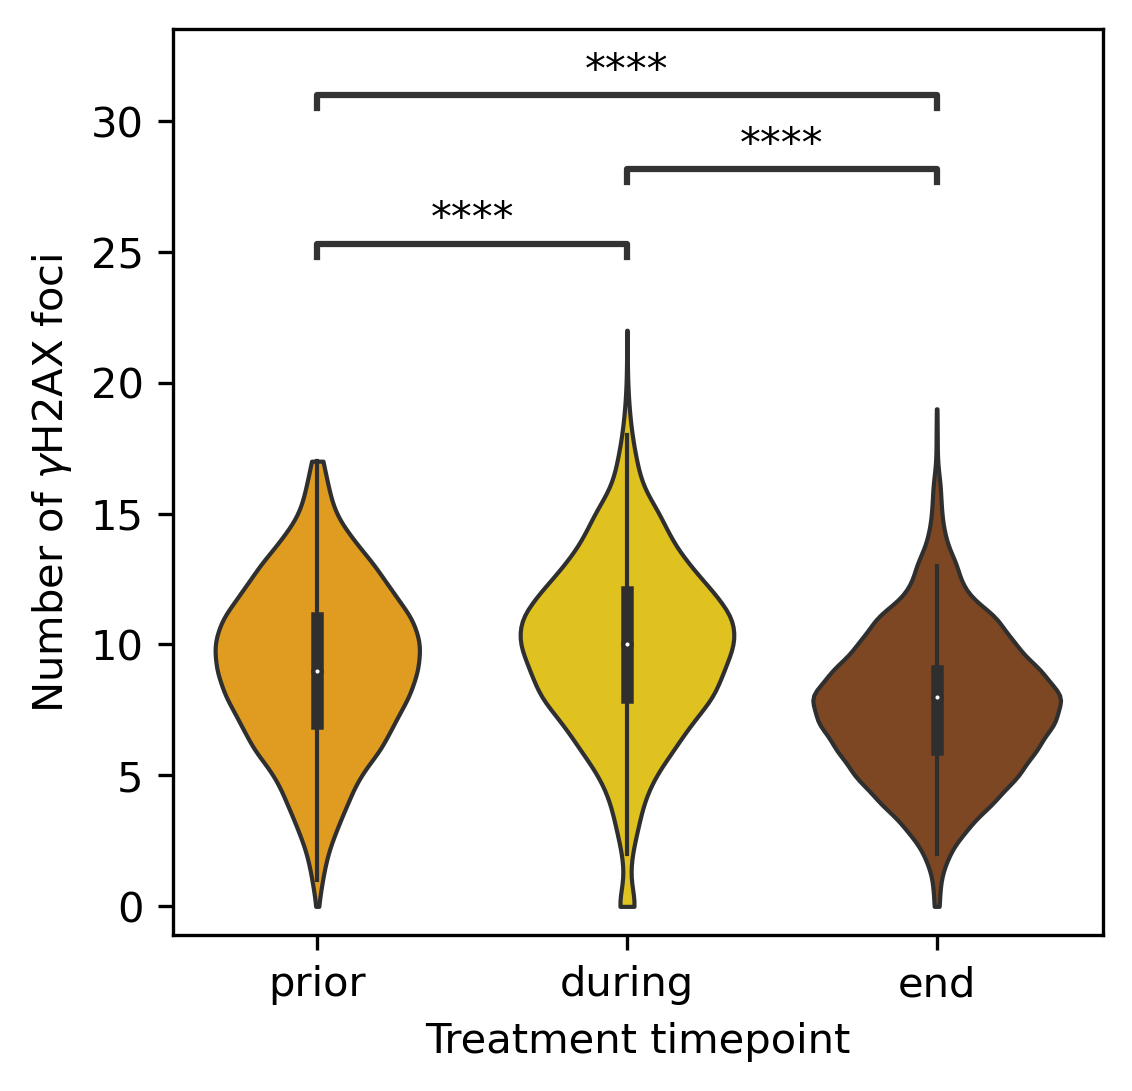

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.478e-28 t=-1.115e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.013e-276 t=3.763e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.974e-137 t=2.562e+01


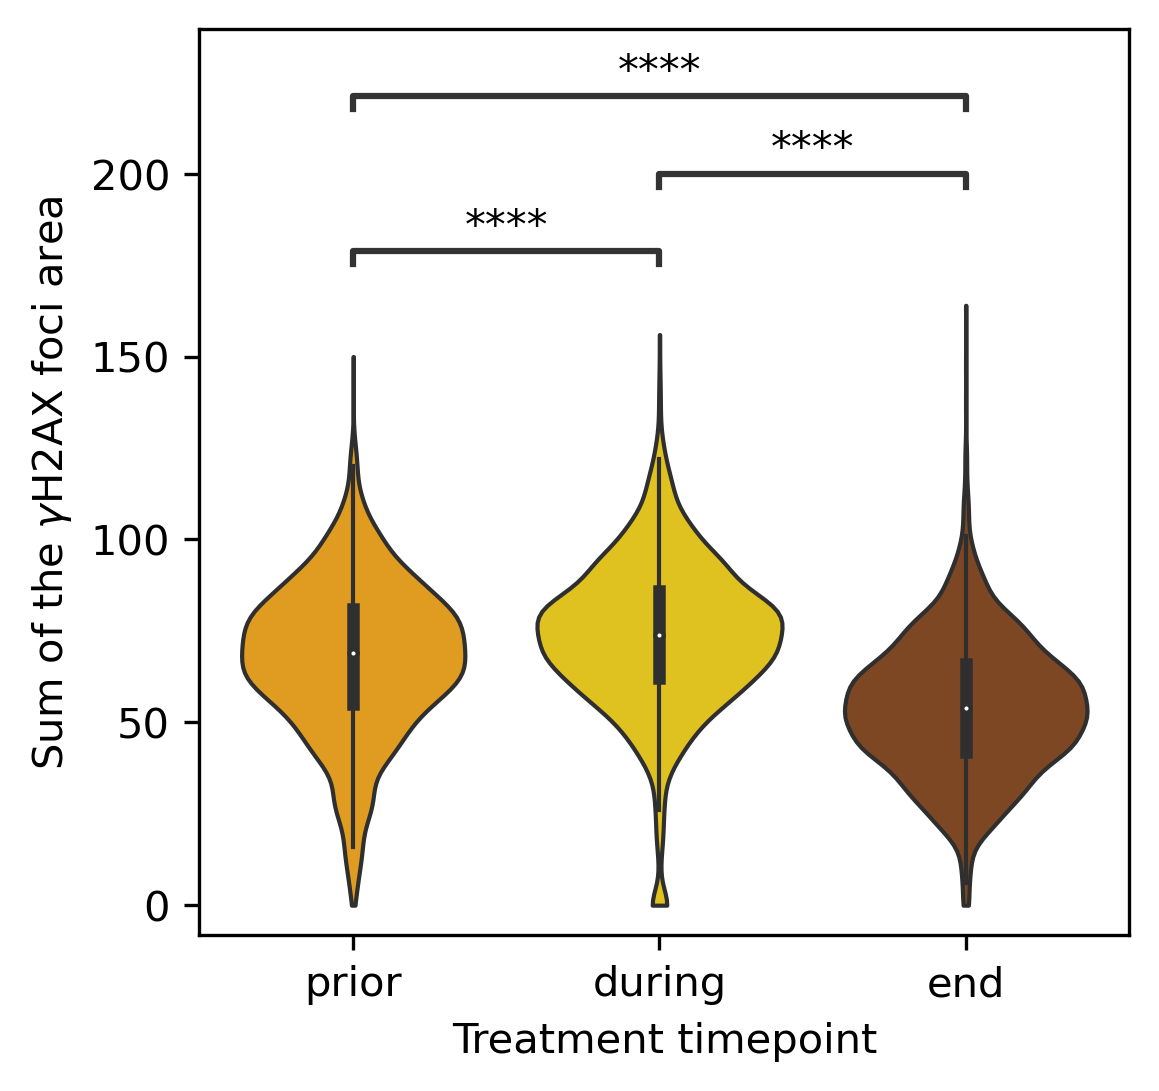

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:2.271e-01 t=-1.208e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.269e-11 t=6.608e+00
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:7.302e-09 t=5.793e+00


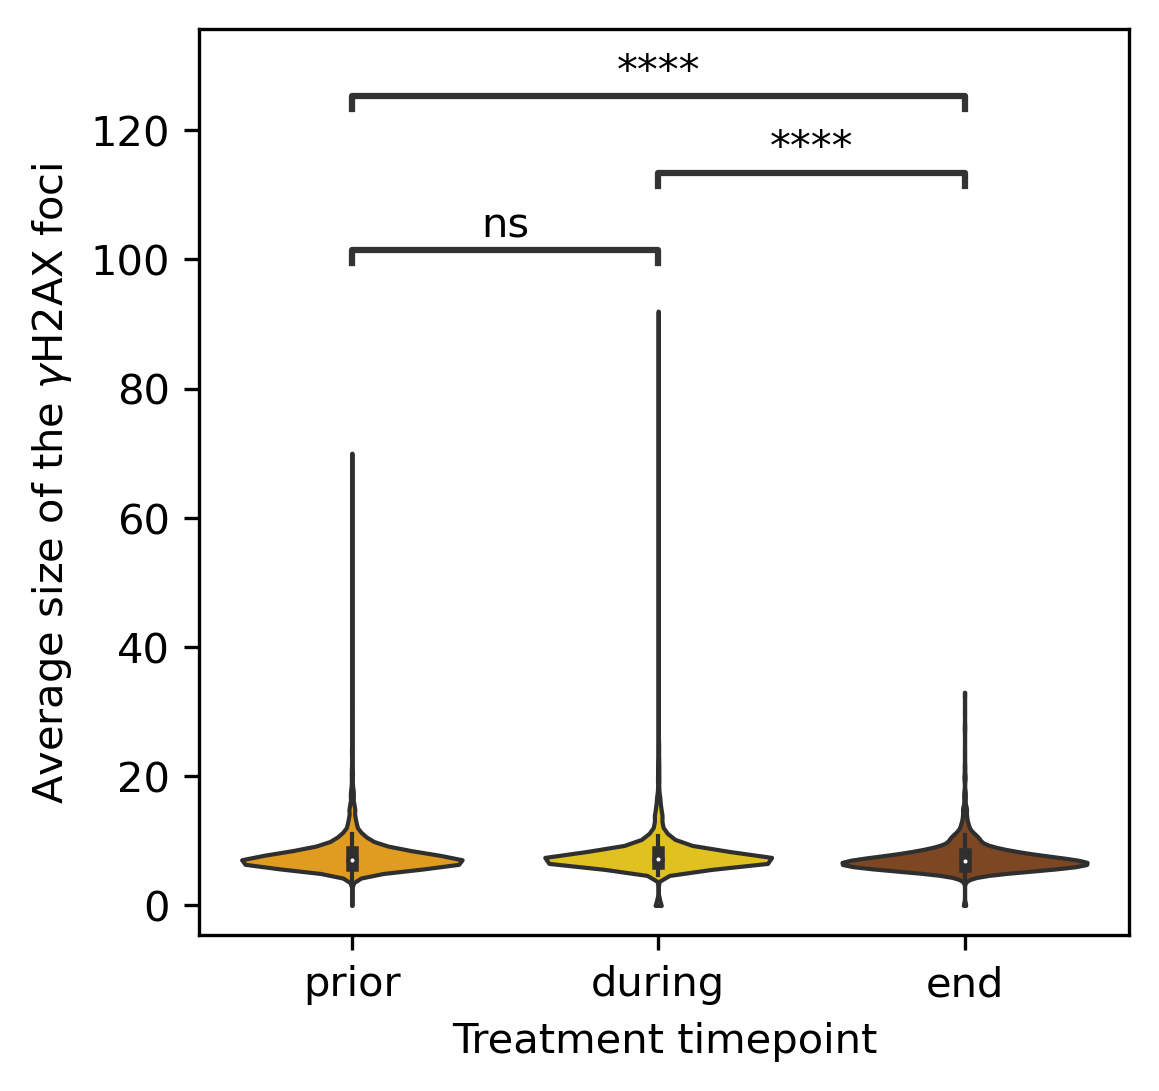

<IPython.core.display.Javascript object>

In [41]:
markers = [
    "rel_lamin_3d_int",
    "rel_gh2ax_3d_int",
    "gh2ax_foci_count",
    "gh2ax_sum_foci_area",
    "gh2ax_avg_foci_area",
]
marker_labels = [
    "Volume-normalized nuclear\nLamin A/C intensity",
    "Normalized nuclear\n" r"$\gamma$H2AX intensity",
    r"Number of $\gamma$H2AX foci",
    r"Sum of the $\gamma$H2AX foci area",
    r"Average size of the $\gamma$H2AX foci",
]
plot_timepoint_markers_dist(
    data,
    markers,
    marker_labels,
    quantiles=None,
    cut=0,
    plot_type="violin",
    palette=color_palette,
)

---

## 4. Supplemental